In [3]:
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from importlib import reload
from glob import glob
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
import commons as g
from commons import peek
g = reload(g)

# Prepare data

## Load city data

### Create the cities

In [4]:
# load the city information
nyc = g.City('nyc')
chi = g.City('chi')
il = g.City('il', dict(name='Illinois', color='tomato', events={}, counties={
    x[-3:]: [17, int(x[-3:])] for x in glob(g.DATA_DIR+'/county_wise/17/*')}))
cities = [nyc, chi, il]

In [ ]:
# cities = [chi, nyc]
cities = [nyc, chi, il]

## Cases/deaths

### NYC

In [8]:
def set_nyc_cases():
    """
    For NYC, the cases data is broken into two parts.
    1. The first part contains values before May 18 and are retrieved from an
    independent Github repo. This table has fewer variables.
    2. The second part contains values on and after May 19 and are collected
    from an official source of the government of NYC. This table has more
    variables like testing rate.
    These two sources have to be combined appropriately but values of one
    particular day (April 26) have to be adjusted because of miscalculation.
    """
    ## before May 18
    # first get the raw data
    cases_old = (
        pd.read_csv(g.IO['nyc_cases_old'])
        .assign(date = lambda x: g.str2date(x['timestamp'].str.slice(0, 10)))
        .drop(columns=['timestamp'])
        .rename(columns={'zcta': 'zip', 'positive': 'cum_cases',
                         'total': 'cum_tests'})
        .query('zip != 99999') # this zip does not exist in reality
        .dropna()
        .astype({'zip': int})
    )
    # 26 Apr is an outlier with a sudden increase in cum. cases with a decline
    # in cum. cases on 27 Apr, so make 26 Apr values avg. of 25 & 27 Apr
    # similarly, 6th Apr data is unavailable, so use avg. of 5 & 7 Apr
    temp = pd.DataFrame()
    for zip_, df in cases_old.groupby('zip'):
        df = df.set_index('date')
        df.loc[g.str2date('2020-04-06')] = np.nan
        for date in g.str2date(pd.Series(['2020-04-06', '2020-04-26'])):
            prev = df.loc[date - pd.DateOffset(1)]
            next_ = df.loc[date + pd.DateOffset(1)]
            df.loc[date] = 0.5*(prev + next_)
        temp = temp.append(df.reset_index(), ignore_index=True)
    cases_old = temp.copy().sort_values('date')
    
    # combine these two units
    cases_old = (
        cases_old.merge(
            cases_old
            .groupby('zip')
            .apply(lambda x: x.set_index('date').diff())
            .rename(columns={'cum_cases': 'new_cases',
                             'cum_tests': 'new_tests'})
            .dropna()
            .astype({'new_cases': int, 'new_tests': int})
            .drop(columns=['zip']),
            on=('zip', 'date'))
        .dropna()
        .set_index(['zip', 'date'])
        .reset_index()
    )
    # after May 18
    cases_new = (
        pd.read_csv(g.IO['nyc_cases_new'])
        .rename(columns=lambda x: x.lower().replace('covid_', ''))
        .rename(columns={'modified_zcta': 'zip', 'pop_denominator': 'popu',
                         'percent_positive': 'pct_positive',
                         'total_tests': 'cum_tests', 'case_count': 'cum_cases',
                         'death_count': 'cum_deaths'})
        .drop(columns=['neighborhood_name'])
        .assign(date = lambda x: g.str2date(x['date']))
        .set_index(['zip', 'date'])
        .reset_index()
        .drop_duplicates(subset=['zip', 'date'])
    )
    cases_new = (
        cases_new.merge(
            cases_new
            .sort_values('date')
            [['zip', 'date', 'cum_cases', 'cum_deaths', 'cum_tests']]
            .groupby('zip')
            .apply(lambda x: x.set_index('date').diff())
            .rename(columns=lambda x: x.replace('cum', 'new'))
            .fillna(0)
            .drop(columns=['zip'])
            .reset_index(),
            on=('zip', 'date')
        )
    )
    # combine the old and new cases
    cases = (
        cases_old.append(cases_new[['zip', 'date', 'cum_cases', 'cum_tests',
                                    'new_cases', 'new_tests']])
            .sort_values(['zip', 'date'])
            .assign(week = lambda x: g.get_week(x['date']))
    )
    # set these as object members
    nyc.cases_old = cases_old
    nyc.cases_new = cases_new
    nyc.cases = cases

In [9]:
set_nyc_cases()
peek(nyc.cases)

Shape: (36476, 7), Memory: 2.226 MB


,zip,date,cum_cases,cum_tests,new_cases,new_tests,week
170,10001.0,2020-04-03,136.0,304.0,23.0,39.0,2020-03-30
301,10001.0,2020-04-04,146.0,321.0,10.0,17.0,2020-03-30
371,10001.0,2020-04-05,158.0,337.0,12.0,16.0,2020-03-30


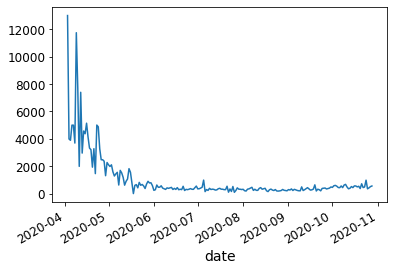

In [10]:
nyc.cases.groupby('date').new_cases.sum().plot();

#### Set important zip codes
These zip codes are the ones which contain the case data.

In [11]:
nyc.imp_zips = pd.Series(nyc.cases['zip'].unique(), name='zip')

### Illinois

In [12]:
il.cases = (pd.read_csv(g.IO['il_cases'])
            .rename(columns={'zipcode': 'zip'})
            .assign(date = lambda x: g.str2date(x['date']))
            .rename(columns=lambda x: x.replace('confirmed_', 'cum_')
                    .replace('total_tested', 'tests'))
            .rename(columns={'cum_cases_change': 'new_cases',
                             'tests_change': 'new_tests',
                             'tests': 'cum_tests'})
            .set_index(['zip', 'date'])
            .apply(lambda x: np.clip(x, 0, np.inf))
            .reset_index())
peek(il.cases, top=2)

Shape: (191544, 48), Memory: 70.146 MB


,zip,date,cum_cases,new_cases,cum_cases_change_pct,cum_cases_20_to_29,cum_cases_30_to_39,cum_cases_40_to_49,cum_cases_50_to_59,cum_cases_60_to_69,...,tests_female,tests_hispanic,tests_leftblank,tests_less_than_20,tests_male,tests_nhpi,tests_unknown,tests_other,tests_unknownleftblank,tests_white
0,62999,2020-12-03,75,2,2.74,12,12,16,10,13,...,495,0,193,81,294,0,0,0,0,643
1,62998,2020-12-03,16,0,0.00,0,0,0,0,0,...,101,0,0,0,60,0,0,0,0,131


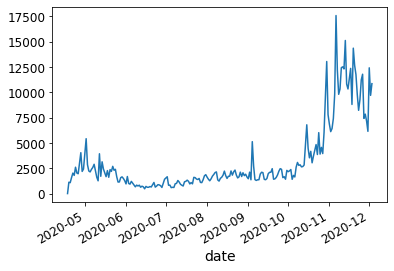

In [13]:
il.cases.groupby('date').new_cases.sum().plot();


In [14]:
il.imp_zips = pd.Series(il.cases['zip'].unique(), name='zip')

### Chicago

In [15]:
chi.case_cols = {
    'ZIP Code':                'zip',
    'Week Number':             'wk_num',
    'Week Start':              'wk_start',
    'Week End':                'wk_end',
    'Cases - Weekly':          'wk_cases',
    'Cases - Cumulative':      'cum_cases',
    'Case Rate - Weekly':      'wk_case_rate',
    'Case Rate - Cumulative':  'cum_case_rate',
    'Tests - Weekly':          'wk_tests',
    'Tests - Cumulative':      'cum_tests',
    'Test Rate - Weekly':      'wk_test_rate',
    'Test Rate - Cumulative':  'cum_test_rate',
    'Percent Tested Positive - Weekly':       'wk_pct_pos',
    'Percent Tested Positive - Cumulative':   'cum_pct_pos',
    'Deaths - Weekly':         'wk_deaths',
    'Deaths - Cumulative':     'cum_deaths',
    'Death Rate - Weekly':     'wk_death_rate',
    'Death Rate - Cumulative': 'cum_death_rate',
    'Population':              'popu',
}

In [16]:
chi.cases = (pd.read_csv(g.IO['chi_cases'])
             .rename(columns=chi.case_cols)
             .query('zip != "Unknown"')
             [chi.case_cols.values()]
             .assign(wk_start = lambda x: g.str2date(x['wk_start'], '%m/%d/%Y'),
                     wk_end = lambda x: g.str2date(x['wk_end'], '%m/%d/%Y'))
             .assign(week = lambda x: x['wk_start'] + pd.DateOffset(days=1))
             .astype({'zip': int, 'wk_num': int})
             .sort_values(['wk_end', 'zip'])
             .set_index(['zip', 'week'])
             .reset_index())

In [17]:
%%time
il.acs = g.load_acs(il)
il.pois = g.load_pois(il)
il.exp_daily = g.load_exposure(il)

CPU times: user 2.25 s, sys: 895 ms, total: 3.15 s
Wall time: 3.26 s


In [18]:
chi.zips = (g.map_cbg_zip(il.acs.index)
            .assign(cnty = lambda x: (x['cbg']//1e7).astype(int))
            .pipe(lambda x: x[x['cnty'].isin([x[0]*1000+x[1] for x in
                                              chi.counties.values()])])
            ['zip'].drop_duplicates())

In [19]:
chi.pois = il.pois[il.pois['zip'].isin(chi.zips)]

In [20]:
chi.cases = il.cases[il.cases['zip'].isin(chi.zips)]

In [21]:
chi.exp_daily = (il.exp_daily.reset_index()
                 .merge(il.pois['cbg'], on='poi_id')
                 .assign(cnty=lambda x: x['cbg']//1e7)
                 .pipe(lambda x: x[x['cnty'].isin([x[0]*1000+x[1] for x in
                                                   chi.counties.values()])])
                 .set_index(['date', 'poi_id'])
                 .drop(columns=['cbg', 'cnty']))

In [22]:
chi.imp_zips = pd.Series(chi.cases['zip'].unique(), name='zip')

#### Set important zip codes
These zip codes are the ones which contain the case data.

In [23]:
chi.imp_zips = pd.Series(chi.cases['zip'].unique(), name='zip')

## Zip code data

### National

In [24]:
zip2tract = g.load_all_zips()
peek(zip2tract)`

Shape: (148897, 6), Memory: 5.680 MB


,zip,state,county,geoid,zpop,zarealand
0,601,72,1,72001956300,18570,166659789
1,601,72,1,72001956400,18570,166659789
2,601,72,1,72001956500,18570,166659789


In [25]:
%%time
zips_shp = (gp.read_file(g.IO['zips_shp'])
            .rename(columns={'ZCTA5CE10': 'zip'})
            .astype({'zip': np.int32}))
peek(zips_shp)

Shape: (33144, 6), Memory: 5.089 MB
CPU times: user 3.41 s, sys: 181 ms, total: 3.59 s
Wall time: 3.82 s


,zip,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry
0,36083,8600000US36083,36083,659750662,5522919,"MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ..."
1,35441,8600000US35441,35441,172850429,8749105,"MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ..."
2,35051,8600000US35051,35051,280236456,5427285,"POLYGON ((-86.74384 33.25002, -86.73802 33.251..."


### Zip shapefile & mapping to CBG

In [26]:
nyc.shp_zip = (gp.read_file(glob(nyc.dir+'/shapefile_zip/*.shp')[0])
               .rename(columns={'postalCode': 'zip'})
               [['zip', 'geometry']]
               .astype({'zip': np.int32}))

In [27]:
il.shp_zip = (zips_shp.merge(zip2tract.query('state == 17')['zip'], on='zip')
              [['zip', 'geometry']])

In [28]:
chi.shp_zip = il.shp_zip.pipe(lambda x: x[x['zip'].isin(chi.zips)])

### Prepare the zip-level data

In [29]:
def get_acs_by_zip(city):
    """
    Aggregate relevant census CBG-level variables over zip codes.
    It's important to use the correct measures & aggregation technique here.
    """
    # get the mapping between CBG & zip code
    zip2cbg = g.map_cbg_zip(city.acs.index, zip2tract)
    # remove 0 population CBGs
    acs = city.acs.query('tot_pop > 0')
    grp = acs.merge(zip2cbg, on='cbg').groupby('zip')
    x = grp[['tot_pop', 'tot_hh', 'tot_income', 'tot_hh_income']].sum().astype(int)
    x['avg_income'] = x['tot_income']/x['tot_pop']
    x['avg_hh_income'] = x['tot_hh_income']/x['tot_hh']
    x['inc_bin'] = g.get_inc_classes(x['avg_income'])
    x['hh_inc_bin'] = g.get_inc_classes(x['avg_hh_income'])
    x['inc_q'] = x['inc_bin'].cat.codes + 1
    x['hh_inc_q'] = x['hh_inc_bin'].cat.codes + 1
    for var in g.VUL_VARS:
        x[var] = grp.apply(g.wtd_avg, val=var, wt='tot_pop')
    return x

In [30]:
for c in cities:
    c.acs_zip = get_acs_by_zip(c)
peek(nyc.acs_zip, top=2)

Shape: (176, 16), Memory: 0.019 MB


,tot_pop,tot_hh,tot_income,tot_hh_income,avg_income,avg_hh_income,inc_bin,hh_inc_bin,inc_q,hh_inc_q,frac_poor,frac_low_edu,frac_old,frac_female,frac_black,frac_transit
zip,,,,,,,,,,,,,,,,
10001,43898,23989,4289277400,4128960500,97710.087020,172118.908666,"(45070.773, 196954.622]","(100524.403, 310580.327]",5,5,0.532339,0.278937,0.112351,0.480204,0.074195,0.449564
10002,82015,34984,2355576600,2173147800,28721.290008,62118.334096,"(25947.574, 32197.228]","(59378.186, 72712.466]",3,2,0.590742,0.676851,0.183783,0.522478,0.090800,0.547970


In [31]:
il.acs_zip = get_acs_by_zip(il)

In [32]:
chi.acs_zip = il.acs_zip.pipe(lambda x: x[x.index.isin(chi.zips)])

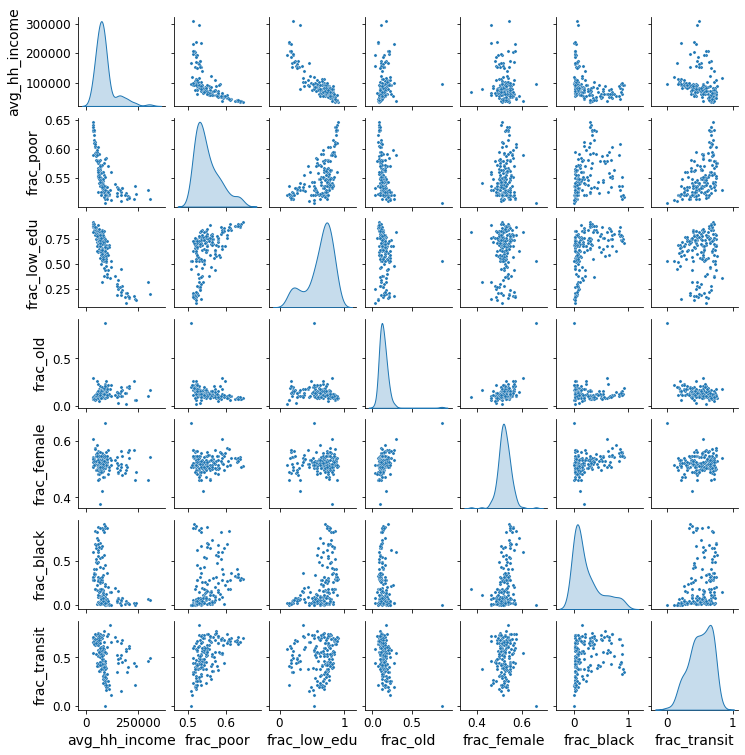

In [33]:
sns.pairplot((nyc.acs_zip
              [['avg_hh_income'] + g.VUL_VARS]),
              diag_kind='kde', height=1.5, plot_kws={'s': 10});

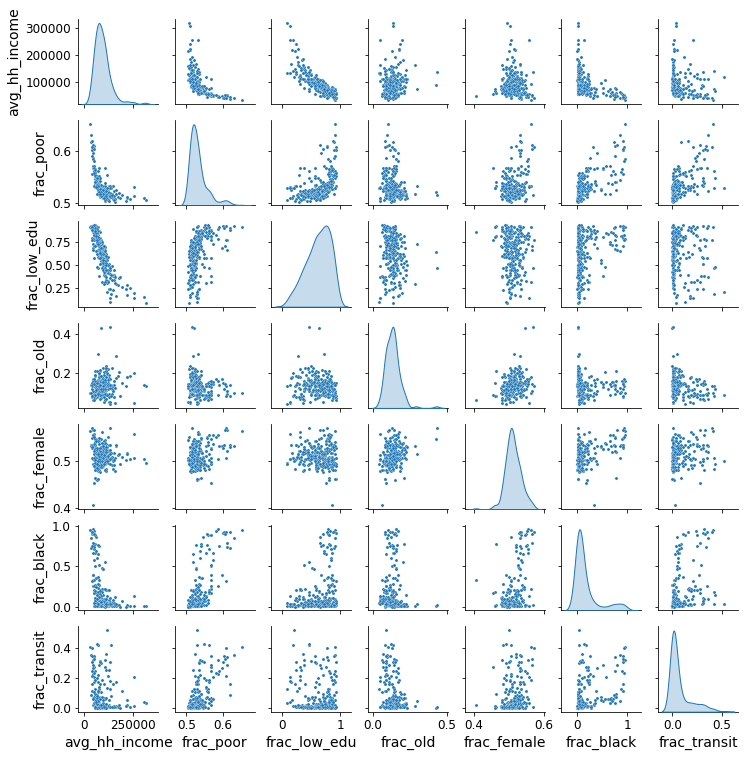

In [34]:
sns.pairplot((chi.acs_zip
              [['avg_hh_income'] + g.VUL_VARS]),
              diag_kind='kde', height=1.5, plot_kws={'s': 10});

## Temp

In [35]:
from scipy.interpolate import make_interp_spline as spline

## Filter in-hospital POIs

### Read all U.S. POIs

In [36]:
%%time
POIS = g.load_all_pois().merge(pd.concat([c.imp_zips for c in cities]))
peek(POIS)

Shape: (427195, 8), Memory: 104.513 MB
CPU times: user 14 s, sys: 1.69 s, total: 15.6 s
Wall time: 25.4 s


,poi_id,location_name,street_address,city,zip,latitude,longitude,parent_poi_id
0,3662,Tenth Avenue Park,825 10th St,Rockford,61104,42.255103,-89.085241,NaN
1,2726124,Rockford Day Nursery Early Learning Ctr,2323 S 6th St,Rockford,61104,42.242128,-89.082270,4328921.0
2,4214757,Illinois Title Loans,923 E State St,Rockford,61104,42.266561,-89.082567,NaN


In [37]:
ALL_NAICS = g.load_all_naics()
peek(ALL_NAICS)

Shape: (2193, 2), Memory: 0.224 MB


,naics,naics_title
0,11,"Agriculture, Forestry, Fishing and Hunting"
1,111,Crop ProductionT
2,1111,Oilseed and Grain Farming


### Remove in-hospital POIs

In [38]:
(
POIS.merge(nyc.pois['naics'], on='poi_id')
[['poi_id', 'parent_poi_id']]
.rename(columns={'poi_id': 'child_id', 'parent_poi_id': 'parent_id'})
.merge(nyc.pois['naics'], left_on='parent_id', right_index=True)
.rename(columns={'naics': 'parent_naics'})
.astype({'parent_id': np.int32})
.merge(ALL_NAICS, left_on='parent_naics', right_on='naics')
.groupby(['naics', 'naics_title']).size().sort_values(ascending=False)
)

naics   naics_title                                                 
611110  Elementary and Secondary Schools                                1688
531120  Lessors of Nonresidential Buildings (except Miniwarehouses)     1300
712190  Nature Parks and Other Similar Institutions                      576
447110  Gasoline Stations with Convenience Stores                        355
713910  Golf Courses and Country Clubs                                   355
622110  General Medical and Surgical Hospitals                           188
711211  Sports Teams and Clubs                                            53
713110  Amusement and Theme Parks                                         47
611310  Colleges, Universities, and Professional Schools                  45
713210  Casinos (except Casino Hotels)                                    34
611210  Junior Colleges                                                   26
611519  Other Technical and Trade Schools                                 23
922140 

In [39]:
def filter_in_naics_pois(city, all_pois=POIS, filt_naics=[622110]):
    """
    Get the list of POIs that lie within another POI which lies in a given
    list of NAICS codes. For the analysis here, only in-hospital (#622110)
    POIs are excluded.
    """
    # get the mapping between 
    child2parent = (
        all_pois.merge(city.pois['naics'], on='poi_id')
        [['poi_id', 'parent_poi_id']]
        .rename(columns={'poi_id': 'child_id', 'parent_poi_id': 'parent_id'})
        .merge(city.pois['naics'], left_on='parent_id', right_index=True)
        .rename(columns={'naics': 'parent_naics'})
        .astype({'parent_id': np.int32})
    )
    # filter the POIs whose parent has NAICS in one of the filt_naics
    if filt_naics is not None:
        child2parent = (child2parent.pipe(lambda x: x[
            x['parent_naics'].isin(filt_naics)]))
    
    return child2parent

In [40]:
for c in cities:
    c.in_hosp_pois = (filter_in_naics_pois(c, filt_naics=[622110])
                      ['child_id'].values)

In [41]:
nyc.pois.loc[nyc.in_hosp_pois].merge(g.IMP_NAICS, on='naics').groupby('naics').size()

naics
445110     2
624410     7
722511    11
722513     6
722515     1
dtype: int64

## Mobility processing

### Calc. total dwell time

In [42]:
# add the columns for visits & total dwell times with 4 and 5 bins
for c in cities:
    if not 'visits5' in c.pat.columns:
        c.pat['visits5'] = c.pat['visits']
        del c.pat['visits']
    c.pat['visits4'] = c.pat[g.DWELL_BINS['names'][:4]].sum(1)
    c.pat['tot_dwell5'] = (c.pat[g.DWELL_BINS['names']].values @
                           g.DWELL_BINS['avg'])
    c.pat['tot_dwell4'] = (c.pat[g.DWELL_BINS['names'][:4]].values @
                           g.DWELL_BINS['avg'][:4])
    c.pat = c.pat.astype({'visits4': np.int32, 'visits5': np.int32,
                          'tot_dwell4': np.int32, 'tot_dwell5': np.int32})

### Join pat_od with pat & expand

In [43]:
def join_pat_pat_od(city, inc_bin_var='hh_inc_bin'):
    """
    Join the POI patterns data with the patterns OD matrix for faster
    downstream analysis.
    """
    pat = (city.pat
           .rename(columns={'visitors': 'poi_visitors', 'zip': 'poi_zip'})
           .drop(columns=['cnty']))
    od_zip = (city.od_zip
              .rename(columns={'date': 'week', 'zip': 'home_zip',
                               'visitors': 'home_visitors'}))
    joined = pat.merge(od_zip, on=('row_id', 'week')).drop(columns='row_id')
    return joined

In [44]:
%%time
for c in tqdm(cities):
    c.odX = join_pat_pat_od(c).rename(columns={'zip': 'poi_zip'})
peek(nyc.odX)

  0%|          | 0/3 [00:00<?, ?it/s]

Shape: (20599696, 20), Memory: 1493.050 MB
CPU times: user 1min 3s, sys: 1min 20s, total: 2min 24s
Wall time: 2min 39s


,poi_id,poi_visitors,med_dwell,week,naics,poi_zip,0-5,5-20,20-60,60-240,>240,exp_visits,tot_cei,cei,visits5,visits4,tot_dwell5,tot_dwell4,home_zip,home_visitors
0,49434,406,76.0,200106,721110,10036,8,127,120,171,133,537,319.759674,0.595456,559,426,63977,32057,1701,4
1,49434,406,76.0,200106,721110,10036,8,127,120,171,133,537,319.759674,0.595456,559,426,63977,32057,6340,4
2,49434,406,76.0,200106,721110,10036,8,127,120,171,133,537,319.759674,0.595456,559,426,63977,32057,7087,4


### Get indices for quick filtering odX

In [45]:
%%time
for c in tqdm(cities):
    print(c.name)
    # mark rows True whose POIs lie in zip codes with case data
    c.odX['imp_zip'] = False
    c.odX.loc[(c.odX['poi_zip'].isin(c.imp_zips)) &
              (c.odX['home_zip'].isin(c.imp_zips)), 'imp_zip'] = True
    
    # mark rows whose POIs lie within hospital
    c.odX['out_hosp'] = True
    c.odX.loc[c.odX['poi_id'].isin(c.in_hosp_pois), 'out_hosp'] = False
    
    # mark rows whose POIs lie in imp_zips & are NOT within hospitals
    c.odX['imp_zip_out_hosp'] = False
    c.odX.loc[(c.odX['imp_zip']==True) & (c.odX['out_hosp']==True),
              'imp_zip_out_hosp'] = True

  0%|          | 0/3 [00:00<?, ?it/s]

NYC
Chicago
Illinois
CPU times: user 6.48 s, sys: 3.89 s, total: 10.4 s
Wall time: 11.4 s


### Filter the zips having case data

In [46]:
"""
Filter the relevant data of a city pertaining to only the zip areas where
health data is available. This is a crucial step because it may greatly
influence the downstream analysis. This step may be skipped to assess the
difference in results between important and all zip codes.
Also optionally skip POIs that lie inside hospitals.
"""
def get_pois(city, imp_zips=False, exclude_in_hosp=True):
    if not imp_zips:
        pois = city.pois
    else:
        pois = city.pois.reset_index().merge(city.imp_zips).set_index('poi_id')
    if exclude_in_hosp:
        pois = pois[~pois.index.isin(city.in_hosp_pois)]
    return pois

def get_acs_zip(city, imp_zips=False):
    if not imp_zips:
        return city.acs_zip
    else:
        acs = city.acs_zip.merge(city.imp_zips, on='zip')
        acs['inc_bin'] = pd.qcut(acs['avg_income'], g.INC_NBINS)
        acs['hh_inc_bin'] = pd.qcut(acs['avg_hh_income'], g.INC_NBINS)
        acs['inc_q'] = acs['inc_bin'].cat.codes + 1
        acs['hh_inc_q'] = acs['hh_inc_bin'].cat.codes + 1
        acs = acs.set_index('zip')
        return acs

def get_pat(city, imp_zips=False, out_hosp=True):
    if not imp_zips:
        pat = city.pat
    else:
        pat = city.pat.merge(city.imp_zips, on='zip')
    if out_hosp:
        pat = pat[~pat['poi_id'].isin(city.in_hosp_pois)]
    return pat

def get_od_zip(city, imp_zips=False):
    if not imp_zips:
        return city.od_zip
    return city.od_zip.merge(city.imp_zips, on='zip')
    
def get_odX(city, imp_zips=False, out_hosp=True):
    odX = city.odX
    if imp_zips and out_hosp:
        odX = odX[odX['imp_zip_out_hosp'] == True]
    else:
        if imp_zips:
            odX = odX[odX['imp_zip'] == True]
        if out_hosp:
            odX = odX[odX['out_hosp'] == True]
    return odX

In [47]:
peek(get_acs_zip(nyc, True), top=2)

Shape: (170, 16), Memory: 0.018 MB


,tot_pop,tot_hh,tot_income,tot_hh_income,avg_income,avg_hh_income,inc_bin,hh_inc_bin,inc_q,hh_inc_q,frac_poor,frac_low_edu,frac_old,frac_female,frac_black,frac_transit
zip,,,,,,,,,,,,,,,,
10001.0,43898,23989,4289277400,4128960500,97710.087020,172118.908666,"(43789.159, 143009.677]","(100869.174, 310580.327]",5,5,0.532339,0.278937,0.112351,0.480204,0.074195,0.449564
10002.0,82015,34984,2355576600,2173147800,28721.290008,62118.334096,"(25724.146, 32300.309]","(59109.18, 72032.337]",3,2,0.590742,0.676851,0.183783,0.522478,0.090800,0.547970


In [48]:
peek(get_pat(nyc, True))

Shape: (1050021, 20), Memory: 76.105 MB


,row_id,poi_id,visitors,med_dwell,week,cnty,naics,zip,0-5,5-20,20-60,60-240,>240,exp_visits,tot_cei,cei,visits5,visits4,tot_dwell5,tot_dwell4
0,0,49434,406,76.0,200106,36061,721110,10036,8,127,120,171,133,537,319.759674,0.595456,559,426,63977,32057
1,0,49434,439,87.0,200113,36061,721110,10036,10,111,100,206,149,539,424.211426,0.787034,576,427,72072,36312
2,0,49434,257,83.0,200120,36061,721110,10036,4,79,69,127,86,328,144.351334,0.440096,365,279,43447,22807


In [49]:
peek(get_od_zip(nyc, True))

Shape: (6344337, 4), Memory: 145.210 MB


,row_id,week,zip,visitors
0,0,200106,10001,4
1,0,200224,10001,4
2,0,200427,10001,4


In [50]:
%time peek(get_odX(nyc, True))

Shape: (14983463, 23), Memory: 1128.858 MB
CPU times: user 1.42 s, sys: 1.76 s, total: 3.18 s
Wall time: 5.78 s


,poi_id,poi_visitors,med_dwell,week,naics,poi_zip,0-5,5-20,20-60,60-240,...,cei,visits5,visits4,tot_dwell5,tot_dwell4,home_zip,home_visitors,imp_zip,out_hosp,imp_zip_out_hosp
14,49434,406,76.0,200106,721110,10036,8,127,120,171,...,0.595456,559,426,63977,32057,10001,4,True,True,True
15,49434,406,76.0,200106,721110,10036,8,127,120,171,...,0.595456,559,426,63977,32057,10002,4,True,True,True
16,49434,406,76.0,200106,721110,10036,8,127,120,171,...,0.595456,559,426,63977,32057,10010,4,True,True,True


### Aggregate comparison of pat with expanded pat_od

In [51]:
%%time
def compare_odx_with_pat(city, imp_zips=True):
    """
    Compare the aggregate level measures of a city's POI patterns table (where
    each row is (POI, week)) with the pat OD extended table (odx) (each row is
    (POI, week, home zip)).
    """
    print('Comparing no. of items of weeks, POIs & week-POIs in pat and odx tables')
    for grp_var in ['week', 'poi_id', ['week', 'poi_id']]:
        print(f'pat: {grp_var}', get_pat(city, imp_zips).groupby(grp_var).size().size)
        print(f'odx: {grp_var}', get_odX(city, imp_zips).groupby(grp_var).size().size)
    
compare_odx_with_pat(nyc, True)

Comparing no. of items of weeks, POIs & week-POIs in pat and odx tables
pat: week 25
odx: week 25
pat: poi_id 63457
odx: poi_id 63240
pat: ['week', 'poi_id'] 1050021
odx: ['week', 'poi_id'] 1040283
CPU times: user 6.68 s, sys: 2.22 s, total: 8.9 s
Wall time: 8.96 s


### Get top specific industry dwellers

In [52]:
def get_top_dweller_pois(city, week, naics, all_pois=POIS, out_hosp=True):
    pat = (get_pat(city, imp_zips=True, out_hosp=out_hosp)
           .query(f'naics == {naics}')
           .query('week == {}'.format(week[2:].replace('-', '')))
           [['poi_id'] + g.DWELL_BINS['names'] + ['visits5', 'tot_dwell5']]
           .assign(avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          )
    pat = (all_pois.merge(pat, on='poi_id')
           .sort_values('tot_dwell5', ascending=False)
           .reset_index(drop=True))
        
    return pat

In [53]:
(get_top_dweller_pois(nyc, '2020-03-23', 722513, out_hosp=False).head(10)
 [['location_name', 'city', 'tot_dwell5', 'parent_poi_id'] + g.DWELL_BINS['names']])

,location_name,city,tot_dwell5,parent_poi_id,0-5,5-20,20-60,60-240,>240
0,Au Bon Pain,Brooklyn,158852,1575069.0,10,179,197,281,444
1,Au Bon Pain,New York,93570,2134234.0,7,93,89,173,262
2,Au Bon Pain,New York,88650,1301786.0,10,114,116,160,244
3,Krispy Krunchy Chicken,Bronx,50655,NaN,8,114,28,55,166
4,Bluestone Lane,New York,34535,NaN,5,69,30,66,94
5,Krispy Krunchy Chicken,Bronx,30807,NaN,5,50,29,35,99
6,239 International Deli,Bronx,28875,NaN,5,53,27,48,83
7,Metro Finest Deli,Brooklyn,27547,NaN,8,135,22,32,84
8,Popeyes Louisiana Kitchen,Brooklyn,25222,NaN,12,93,36,37,71
9,Little Caesars,Brooklyn,22190,NaN,9,75,35,57,47


---
# Visualization

## Static

### Zips map

In [54]:
def plot_map_zips(city, cntys=None, cbgs=True, epsg=4326, figsize=(10, 10)):
    """
    Plot the map of the zip areas and see how they are different from CBGs
    (overlaps). Use either all zips or only the ones with the case data
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    zip_df = city.shp_zip.copy()
    if cntys is not None:
        cnty_df = (city.shp_cnty.astype({'COUNTYFP': int})
                   .pipe(lambda x: x[x['COUNTYFP'].isin(cntys)]))
        cbg_df = (city.shp_cbg.astype({'countyfp': int})
                  .pipe(lambda x: x[x['countyfp'].isin(cntys)]))
    else:
        cnty_df = city.shp_cnty
        cbg_df = city.shp_cbg
    zip_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
    cnty_df.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1.5)
    if cbgs:
        cbg_df.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=.2)

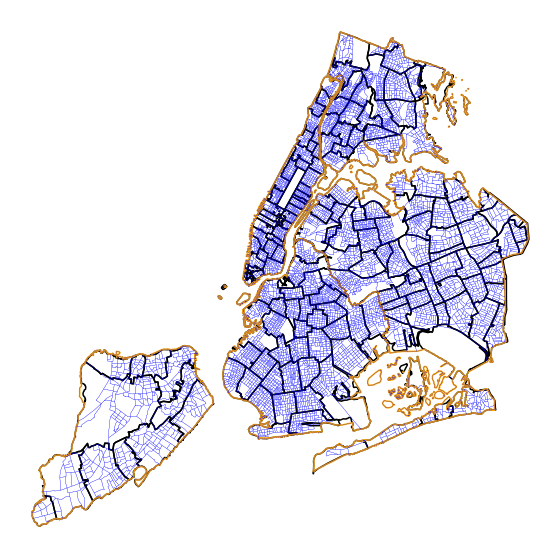

In [55]:
plot_map_zips(nyc, cntys=[61, 5, 81, 47, 85])

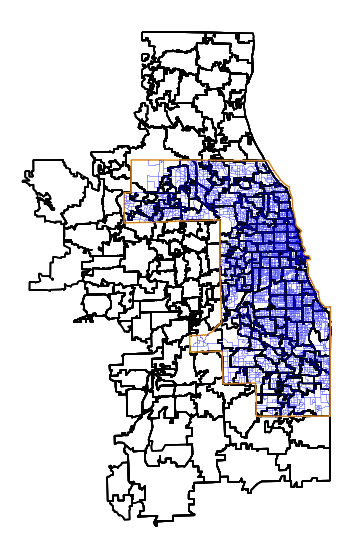

In [56]:
plot_map_zips(chi, cntys=[31])

In [57]:
def plot_map_cases(city, cntys=None, epsg=4326, figsize=(10, 10)):
    """
    Plot the map of cases by zip code.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    zip_df = city.shp_zip.copy()
    if cntys is not None:
        cnty_df = (city.shp_cnty.astype({'COUNTYFP': int})
                   .pipe(lambda x: x[x['COUNTYFP'].isin(cntys)]))
        cbg_df = (city.shp_cbg.astype({'countyfp': int})
                  .pipe(lambda x: x[x['countyfp'].isin(cntys)]))
    else:
        cnty_df = city.shp_cnty
        cbg_df = city.shp_cbg
    zip_df.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1.5)
    cnty_df.plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=1.5)
    cbg_df.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=.2)

### Population composition by income

In [58]:
def plot_pie_by_inc_class(city, var='tot_pop', imp_zips=True, inc_bin_var='hh_inc_bin'):
    """
    Plot the pie chart of an extensive measure by city's income classes.
    """
    # get the zip-level census data
    acs = get_acs_zip(city, imp_zips)
    
    df = acs.groupby(inc_bin_var)[var].sum()
    colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
    labels = [f'{x.left/1e3:.0f}k - {x.right/1e3:.0f}k' for x in df.index.tolist()]
    df.plot(kind='pie', colors=colors, labels=labels,
            autopct='%.1f%%', startangle=90)
    plt.ylabel('')

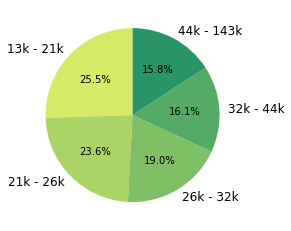

In [59]:
plot_pie_by_inc_class(nyc, var='tot_pop', inc_bin_var='inc_bin')

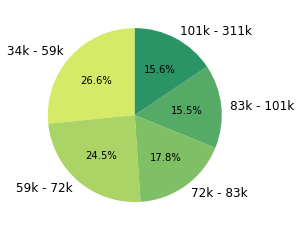

In [60]:
plot_pie_by_inc_class(nyc, var='tot_pop', inc_bin_var='hh_inc_bin')

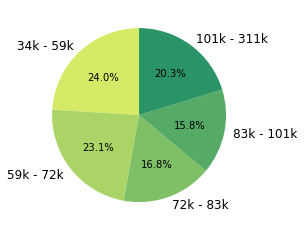

In [61]:
plot_pie_by_inc_class(nyc, var='tot_hh', inc_bin_var='hh_inc_bin')

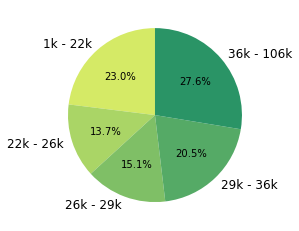

In [62]:
plot_pie_by_inc_class(il, var='tot_pop', inc_bin_var='inc_bin')

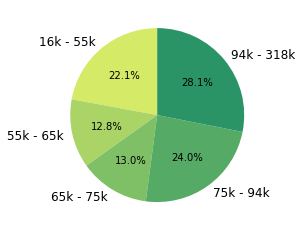

In [63]:
plot_pie_by_inc_class(il, var='tot_pop', inc_bin_var='hh_inc_bin')

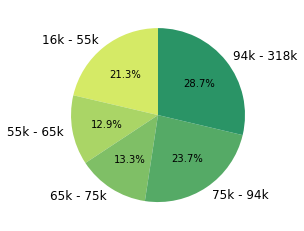

In [64]:
plot_pie_by_inc_class(il, var='tot_hh', inc_bin_var='hh_inc_bin')

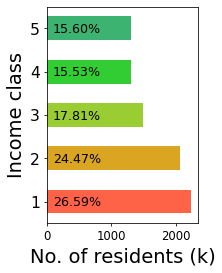

In [65]:
def plot_popu_by_inc_class(city, var='tot_pop', imp_zips=True,
                           inc_bin_q='hh_inc_q', dpi=70):
    # get the zip-level census data
    acs = get_acs_zip(city, imp_zips)
    vals = acs.groupby(inc_bin_q)[var].sum()/1e3
    vals = pd.concat([vals, (vals/vals.sum()).rename('proportion')], axis=1)
    inc_q_map = {1:2,2:4,3:3,4:1,5:5}
    # plot
    fig, ax = plt.subplots(figsize=(2.8, 4.1), dpi=dpi)
    plt.barh(vals.index, vals[var], color=g.COLORS['income_classes5'],
             height=0.55)
    plt.ylabel('Income class', fontsize=20)
    plt.yticks(fontsize=16)
#     plt.title('Population income\n distribution', fontsize=18)
    plt.xlabel('No. of residents (k)', fontsize=20)
    for i, v in enumerate(vals['proportion']):
        ax.text(v+100, i+0.9, f'{v*100:.2f}%', color='k', fontsize=13)
    return inc_q_map

_ = plot_popu_by_inc_class(nyc, dpi=70)

### POI visitors to visits ratio

In [66]:
def plot_visit_visitor_ratio(city, imp_zips=True):
    """
    Plot the trend of ratio of visits to visitors to POIs of a city.
    """
    ratios = (get_pat(city, imp_zips)
              .groupby(['week'])
              [['visits5', 'visitors']].sum()
              .reset_index()
              .assign(ratio = lambda x: x['visits5']/x['visitors'],
                      week = lambda x: g.int2date(x['week']))
              .set_index('week')['ratio']
             )
    ratios.plot(marker='o')
    plt.title('Ratio of total POI visits to total visitors in '+
              city.name)
    plt.ylabel('Visits/Visitors')
    plt.xlabel('')

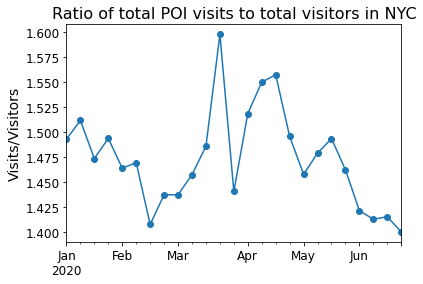

In [67]:
plot_visit_visitor_ratio(nyc)

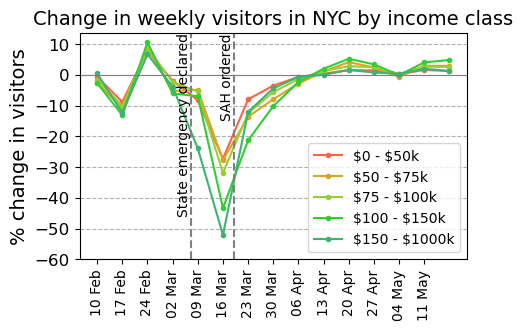

In [68]:
def plot_trend_mob_by_income(dpi=70):
    bins = [0, 50, 75, 100, 150, 1000]
    inc = (pd.cut((nyc.acs['avg_hh_income']/1e3).dropna(),
                  bins)).rename('inc_bin')
    res = (get_pat(nyc, True)
           .merge(nyc.pois['cbg'], on='poi_id')
           .merge(inc, on='cbg')
           .assign(inc_q = lambda x: (x['inc_bin'].cat.codes+1).map(_))
           .query('inc_q > 0')
           .groupby(['inc_q', 'week'])
           ['visits5'].sum()
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index('week')
           .pipe(lambda x: x[(x.index <= g.int2date(200520)) &
                             (x.index >= g.int2date(200130))]))
    fig, ax = plt.subplots(figsize=(5, 3), dpi=dpi)
    colors = g.COLORS['income_classes5']
    labels = {i+1: f'\${bins[i]} - \${bins[i+1]}k' for i in range(len(bins)-1)}
    plt.xticks(pd.date_range('2020-02-03', '2020-05-11', freq='7D'),
               rotation=90, fontsize=10)
    for i, (inc_q, df) in enumerate(res.groupby('inc_q')):
        ax.plot((df['visits5']/1e6).diff()*100, color=colors[i],
                marker='.', label=labels[inc_q])
    plt.title('Change in weekly visitors in NYC by income class', fontsize=14)
    plt.legend(fontsize=10)
    plt.xlabel('')
    plt.ylabel('% change in visitors')
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b'))
    ax.set_yticks(np.arange(-60, 20, 10))
    ax.yaxis.grid(ls='--')
    ax.axhline(0, color='grey', lw=0.8)
    for evt, date in [('State emergency declared', 200307), ('SAH ordered', 200319)]:
        ax.axvline(g.int2date(date), color='grey', ls='--')
        ax.text(g.int2date(date), ax.get_ylim()[1], evt, ha='right', va='top',
                rotation=90)
#     return res
plot_trend_mob_by_income(dpi=100)

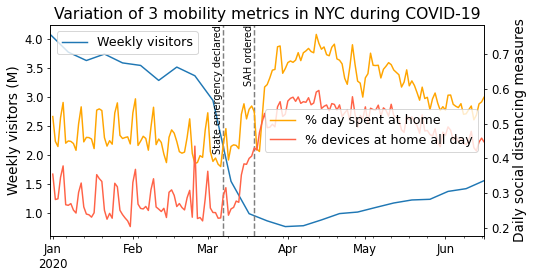

In [69]:
def plot_mob_trend(city):
    fig, ax1 = plt.subplots(figsize=(8, 4), dpi=70)
    ax2 = ax1.twinx()
    (city.sd
     .assign(tot_time_home = lambda x: x['tot_dev']*x['time_home'])
     .groupby('date').sum()
     .assign(time_home = lambda x: x['tot_time_home']/x['tot_dev']/24,
             prop_home = lambda x: x['dev_home']/x['tot_dev'])
     [['time_home', 'prop_home']]
     .plot(ax=ax2, color=['orange', 'tomato'])
    )
    ax2.legend(labels=['% day spent at home', '% devices at home all day'],
               loc='center right')
    ((city.pat.groupby('week')['visitors'].sum()/1e6)
     .reset_index()
     .assign(week = lambda x: g.int2date(x['week']))
     .set_index('week')
     .plot(ax=ax1, label='Visitors')
    )
    for evt, date in [('State emergency declared', 200307), ('SAH ordered', 200319)]:
        ax1.axvline(g.int2date(date), ls='--', color='grey')
        ax1.text(g.int2date(date), ax1.get_ylim()[1], evt, color='k',
                 ha='right', va='top', rotation=90)
    ax1.legend(labels=['Weekly visitors'], loc='upper left')
    ax1.set_xlabel('')
    ax1.set_ylabel('Weekly visitors (M)')
    ax2.set_ylabel('Daily social distancing measures')
    plt.title('Variation of 3 mobility metrics in NYC during COVID-19')
    
plot_mob_trend(nyc)

### POI visits by income

In [70]:
def get_poi_vis_by_poi_inc(city, var='visits5', imp_zips=True, plot=False):
    """
    Get the weekly visits or visitors to the POIs totalled by the income class
    of the zip code in which the POI lies.
    @param var: <str> POI-based measure of mobility (either `poi_visits` or
    `poi_visitors`)
    @param imp_zip: whether include only the zips with cases data
    """
    # get the expanded zip OD matrix (with POI attrs) & get its income
    res = (get_odX(city, imp_zips)
           .merge(city.acs_zip['hh_inc_q'], left_on='poi_zip', right_index=True)
           .rename(columns={'hh_inc_q': 'poi_inc_q'})
           .groupby(['week', 'poi_id', 'poi_inc_q'])
           [[var]].first()
           .groupby(['week', 'poi_inc_q'])
           .sum()
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week'], fmt='%y%m%d'))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby('poi_inc_q'), colors):
            (df[var]/1e3).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        ylabel = ''
        if var == 'visits5': ylabel = 'Visits (k)'
        if var == 'visitors': ylabel = 'Visitors (k)'
        plt.ylabel(ylabel)
        plt.title(f'Weekly {var} by income quintile\n' +
                  'of POI zip in ' + city.name);
        plt.legend()
    return res

CPU times: user 9.15 s, sys: 3.94 s, total: 13.1 s
Wall time: 13.1 s


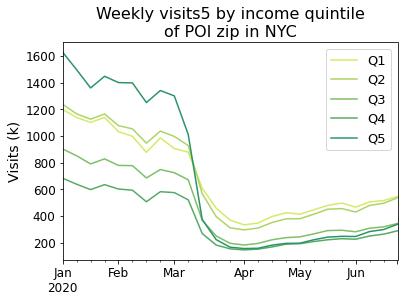

In [71]:
%time _ = get_poi_vis_by_poi_inc(nyc, plot=True);

CPU times: user 8.73 s, sys: 3.39 s, total: 12.1 s
Wall time: 12.2 s


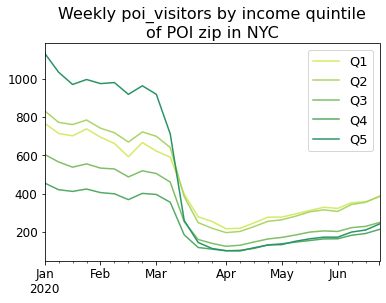

In [72]:
%time _ = get_poi_vis_by_poi_inc(nyc, var='poi_visitors', plot=True);

<b>Inference</b>: More people come to richer POIs than poorer POIs.

<b>Inference</b>: More people come to richer POIs than poorer POIs.

### Home visitors by income

In [73]:
def get_poi_vis_by_home_inc(city, imp_zips=True, plot=False):
    """
    Get the weekly visits to the POIs totalled by the income class of the zip
    code in which the POI lies.
    """
    res = (get_odX(city, imp_zips)
           .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                  left_on='home_zip', right_index=True)
           .groupby(['week', 'home_inc_q'])
           ['home_visitors'].sum()
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week'], fmt='%y%m%d'))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby(['home_inc_q']), colors):
            (df['home_visitors']/1e6).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        plt.ylabel('Visitors (M)')
        plt.legend()
        plt.title('Weekly home visitors by income\n' +
                  'quintile of home zip in ' + city.name);
    return res

CPU times: user 12 s, sys: 2.53 s, total: 14.5 s
Wall time: 14.5 s


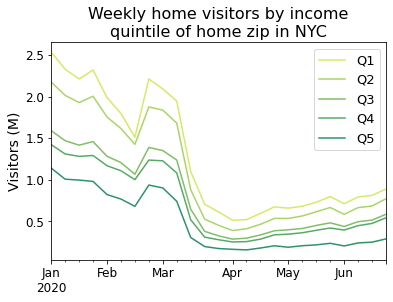

In [74]:
%time _ = get_poi_vis_by_home_inc(nyc, plot=True)

<b>Inference</b>: Fewer rich people travel compared to poorer people, both before & after lockdown.

<b>Inference</b>: Fewer rich people travel compared to poorer people, both before & after lockdown.

## Dwell-time visualization

### Dwell time by POI zip income

### Dwell time by home zip income

In [75]:
def get_dwell_by_home_inc(city, imp_zips=True, nbins=5,
                          imp_naics=False, plot=False):
    """
    Get the weekly trend of average dwell time over income class of home
    visitors.
    @param imp_naics: whether filter the OD data for only the important naics
    """
    # get the expanded patterns OD matrix
    odX = get_odX(city, imp_zips)
    # filter the NAICS, if required
    odX = odX[odX['naics'].isin(g.IMP_NAICS.index)] if imp_naics else odX
        
    # first get the no. of home visitors by POI & home zip income class
    res = (odX.rename(columns={f'tot_dwell{nbins}': 'tot_dwell'})
           .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                  left_on='home_zip', right_index=True)
           .groupby(['week', 'poi_id', 'home_inc_q'])
           .agg({'tot_dwell': 'first', 'home_visitors': sum})
           .reset_index('home_inc_q')
          )
    # calculate the total home visitors of each POI
    tot_vis_by_poi = (res.groupby(['week', 'poi_id'])
                      ['home_visitors'].sum()
                      .rename('tot_home_visitors')
                     )
    # now distribute the POI total dwell time into its income class components
    # in proportion of the home visitors in its income classes
    res = (res
           .merge(tot_vis_by_poi, on=('week', 'poi_id'))
           .astype({'tot_dwell': float, 'home_visitors': int,
                    'tot_home_visitors': float})
           .assign(tot_dwell_inc = lambda x:
                   x['tot_dwell']*x['home_visitors']/x['tot_home_visitors'])
           .drop(columns=['tot_dwell'])
           .rename(columns={'tot_dwell_inc': 'tot_dwell'})
           .groupby(['week', 'home_inc_q'])
           .sum()
           .assign(avg_dwell = lambda x: x['tot_dwell']/x['home_visitors'])
           .drop(columns=['tot_dwell', 'tot_home_visitors'])
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby(['home_inc_q']), colors):
            (df['avg_dwell']).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        plt.ylabel('Dwell time (min)')
        plt.legend()
        plt.title(f'Weekly avg. dwell time ({nbins} bins) by income\n' +
                  'quintile of home zip in ' + city.name);
    return res

CPU times: user 18.8 s, sys: 4.19 s, total: 23 s
Wall time: 23.2 s


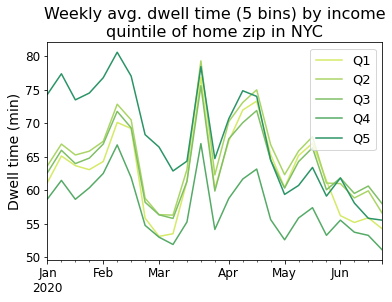

In [76]:
%time _ = get_dwell_by_home_inc(nyc, plot=True)

CPU times: user 11.3 s, sys: 2.35 s, total: 13.6 s
Wall time: 13.6 s


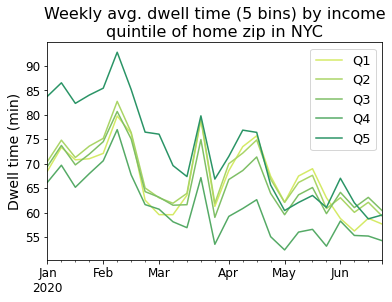

In [77]:
%time _ = get_dwell_by_home_inc(nyc, imp_naics=True, plot=True)

CPU times: user 18.6 s, sys: 3.99 s, total: 22.6 s
Wall time: 22.7 s


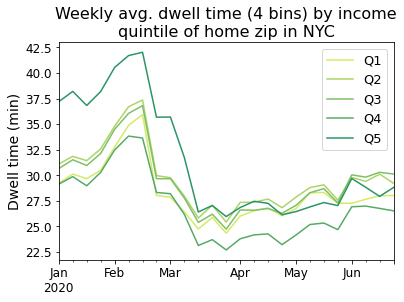

In [78]:
%time _ = get_dwell_by_home_inc(nyc, nbins=4, plot=True)

CPU times: user 11.4 s, sys: 2.33 s, total: 13.7 s
Wall time: 13.8 s


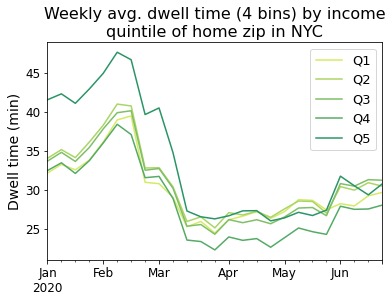

In [79]:
%time _ = get_dwell_by_home_inc(nyc, nbins=4, imp_naics=True, plot=True)

### Dwell time by industry

In [80]:
def get_vis_by_dwell_naics(city, imp_zips=True):
    """
    Calc. the total weekly POI visits by industry in different dwell time
    buckets.
    """
    res = (get_pat(city, imp_zips)
           [['week', 'naics'] + g.DWELL_BINS['names']]
           .merge(g.IMP_NAICS['category'], on='naics')
           .drop(columns='naics')
           .groupby(['category', 'week'])
           .sum()
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index(['category', 'week'])
          )
    return res

In [81]:
peek(get_vis_by_dwell_naics(nyc))

Shape: (300, 5), Memory: 0.014 MB


0-5    5-20   20-60  60-240    >240
category  week                                             
Bars/Pubs 2020-01-06  708.0  7138.0  5015.0  6764.0  4734.0
          2020-01-13  618.0  6391.0  4578.0  6390.0  4496.0
          2020-01-20  518.0  6137.0  4506.0  6293.0  4358.0

In [82]:
def plot_visits_by_naics_dwell_bin(city, imp_zips=True,
                                   pre_date=None, post_date=None):
    """
    Plot the trend of total weekly visits by dwell-time bucket and industry.
    @param pre_date, post_date: <str> dates to be considered representative
    of the pre-restriction and post-restriction era (must be a Monday)
    """
    data = get_vis_by_dwell_naics(city, imp_zips)
    fig, ax = plt.subplots(3, 4, figsize=(16, 9), dpi=60, sharex=True)
    ax = ax.flatten()
    for i, (cat, df) in enumerate(data.groupby('category')):
        ((df.reset_index('category', drop=True)/1e3)
         .plot(ax=ax[i], color=sns.color_palette(g.CMAPS['dwell_bins'], 5)))
        if i != 0:
            ax[i].legend().remove()
        ax[i].set_title('{} ({:.0f}k)'.format(cat, df.sum().mean()/1e3))
        
        # plot dates
        if pre_date is not None:
            ax[i].axvline(g.str2date(pre_date), color='grey')
        if post_date is not None:
            ax[i].axvline(g.str2date(post_date), color='grey')
    fig.suptitle('Weekly visits (k) by dwell time buckets across industry in ' +
                 city.name + '\n (all-time weekly average shown in parentheses)',
                 fontsize=20, y=0.98)
    plt.tight_layout()

CPU times: user 3.82 s, sys: 131 ms, total: 3.95 s
Wall time: 2.07 s


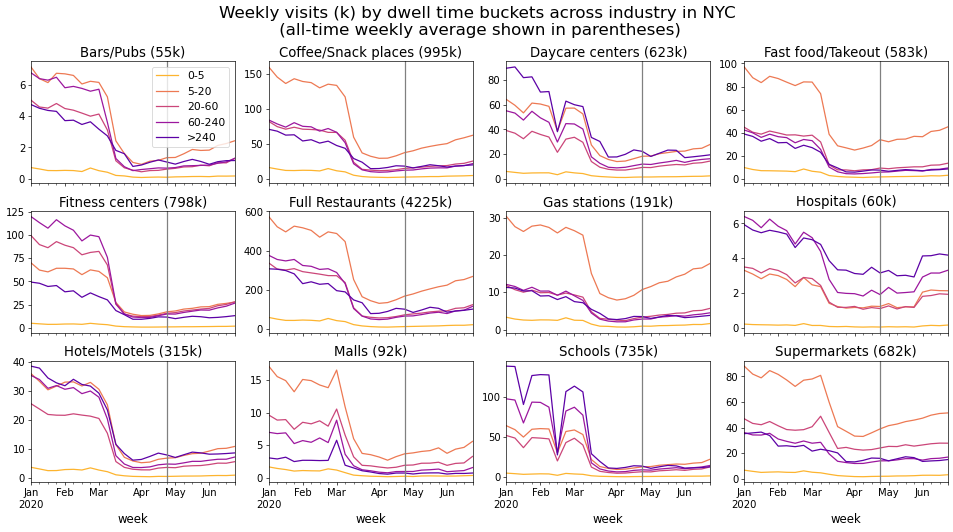

In [83]:
%time plot_visits_by_naics_dwell_bin(nyc, '2020-01-27', '2020-04-27')

### Dwell time distribution on a date

In [84]:
def get_dwell_distr_by_naics_on(city, date, imp_zips=True, plot=False):
    """
    Filter the discrete probability distribution of dwell time a city on a
    particular date by industry, used to compare the change in composition.
    """
    res = (get_vis_by_dwell_naics(city, imp_zips)
          .reset_index('category')
          .loc[g.str2date(date)]
          .set_index('category'))
    res = res.divide(res.sum(1), axis=0)
    
    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        res.plot.barh(ax=ax, stacked=True, cmap=g.CMAPS['dwell_bins'])
        plt.legend(bbox_to_anchor=(1.01, 1))
        plt.ylabel('')
        plt.title('Dwell time composition by industry:\n{}, {}'
                  .format(city.name, g.str2date(date).strftime('%d %b')))
    
    return res

Shape: (12, 5), Memory: 0.001 MB


,0-5,5-20,20-60,60-240,>240
category,,,,,
Bars/Pubs,0.022477,0.295009,0.210358,0.283836,0.188319
Coffee/Snack places,0.032114,0.384382,0.198342,0.215813,0.169350
Daycare centers,0.019157,0.253738,0.159050,0.226239,0.341816


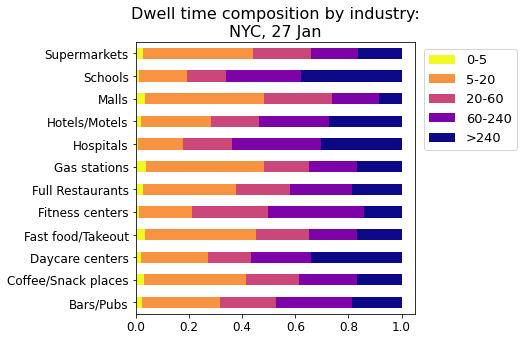

In [85]:
_ = get_dwell_distr_by_naics_on(nyc, '2020-01-27', plot=True)
peek(_)

### Change in dwell time distribution

In [86]:
def get_change_dwell_distr(city, b4_date, aft_date, plot=False):
    """
    Get the difference in the dwell time discrete probability distribution of a
    city between two dates by industry to see how dwell time buckets had
    different relative change in proportion of visits by industry.
    """
    # get the distributions on before and after dates
    b4_distr = get_dwell_distr_by_naics_on(city, b4_date)
    aft_distr = get_dwell_distr_by_naics_on(city, aft_date)
    # get the element wise difference to get change in percentage points
    res = (aft_distr - b4_distr) * 100
    
    if plot:
        fig, ax = plt.subplots(figsize=(5, 5))
        res.plot.barh(ax=ax, stacked=True, cmap=g.CMAPS['dwell_bins'])
        plt.legend(bbox_to_anchor=(1.01, 1))
        plt.ylabel('')
        plt.xlabel('Change in percentage points')
        plt.title('Change in dwell time composition in {} \n between {} and {}'
              .format(city.name, g.str2date(b4_date).strftime('%d %b'),
                      g.str2date(aft_date).strftime('%d %b')))
    return res

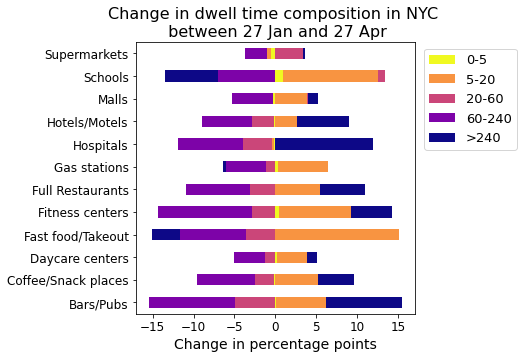

In [87]:
_ = get_change_dwell_distr(nyc, '2020-01-27', '2020-04-27', plot=True)

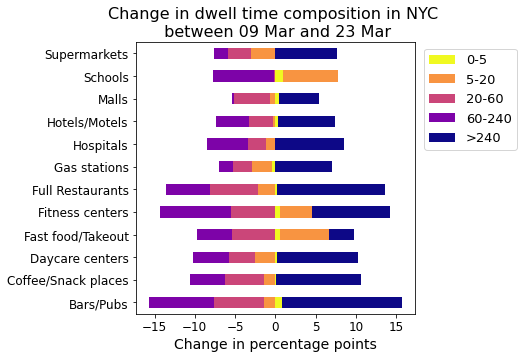

In [88]:
_ = get_change_dwell_distr(nyc, '2020-03-09', '2020-03-23', plot=True)

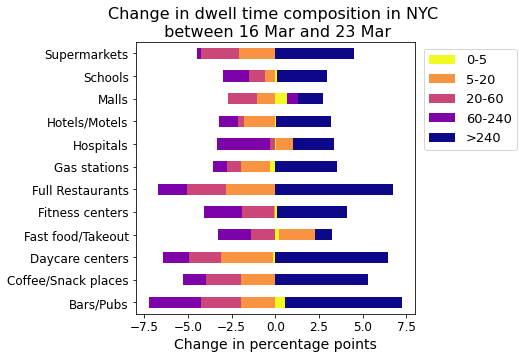

In [89]:
_ = get_change_dwell_distr(nyc, '2020-03-16', '2020-03-23', plot=True)

## Investigate dwell time

In [90]:
city = nyc

In [91]:
(nyc.pois.loc[nyc.in_hosp_pois]
 .query('naics == 722513')
 .merge(POIS.drop(columns=['zip']), on='poi_id')
 .merge(nyc.acs_zip['hh_inc_q'], on='zip')
 .rename(columns={'hh_inc_q': 'poi_income_q'})
 [['location_name', 'street_address', 'city', 'poi_income_q']]
)

,location_name,street_address,city,poi_income_q
0,Au Bon Pain,1400 Pelham Parkway South Store House Building,New York,2
1,Au Bon Pain,7901 Broadway,Elmhurst,2
2,Au Bon Pain,462 1st Ave,New York,5
3,Au Bon Pain,2601 Ocean Pkwy,Brooklyn,2


In [92]:
(get_pat(nyc, True, True)
 .query('naics == 722513 & week == 200330')
 .merge(nyc.acs_zip['hh_inc_q'], on='zip')
 [['poi_id', 'hh_inc_q', 'visits5', 'tot_dwell5']]
 .set_index('poi_id').sort_index()
).join(
    (get_odX(nyc, True, True)
    .query('naics == 722513 & week == 200330')
    .merge(nyc.acs_zip['hh_inc_q'], left_on='poi_zip', right_index=True)
    [['poi_id', 'hh_inc_q', 'visits5', 'tot_dwell5']]
    .groupby('poi_id').first().sort_index()
    ),
    lsuffix='_pat', rsuffix='_odX'
)

,hh_inc_q_pat,visits5_pat,tot_dwell5_pat,hh_inc_q_odX,visits5_odX,tot_dwell5_odX
poi_id,,,,,,
8715,3,18,342,3.0,18.0,342.0
9531,2,21,1957,2.0,21.0,1957.0
10506,5,18,1920,5.0,18.0,1920.0
10803,4,11,1122,4.0,11.0,1122.0
12602,4,93,3667,4.0,93.0,3667.0
...,...,...,...,...,...,...
5245485,5,9,320,5.0,9.0,320.0
5255351,4,28,880,4.0,28.0,880.0
5263510,1,21,3015,1.0,21.0,3015.0


In [93]:
%%time
(get_odX(nyc, True, True)
 .query('naics == 722513 & week == 200330')
 .merge(nyc.acs_zip['hh_inc_q'], left_on='poi_zip', right_index=True)
 [['poi_id', 'hh_inc_q', 'visits5', 'tot_dwell5']]
 .groupby('poi_id').first().sort_index()
)

CPU times: user 1.26 s, sys: 554 ms, total: 1.82 s
Wall time: 1.81 s


,hh_inc_q,visits5,tot_dwell5
poi_id,,,
8715,3,18,342
9531,2,21,1957
10506,5,18,1920
10803,4,11,1122
12602,4,93,3667
...,...,...,...
5245485,5,9,320
5255351,4,28,880
5263510,1,21,3015


CPU times: user 890 ms, sys: 225 ms, total: 1.12 s
Wall time: 1.12 s


Text(0.5, 0, 'Income quintile of POI ZCTAs')

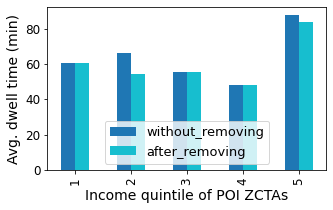

In [94]:
%%time
pd.concat([
    (get_pat(city, imp_zips=True, out_hosp=False)
     .pipe(lambda x: x[x.week == 200330])
     .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'), on='zip')
     .merge(g.IMP_NAICS['category'], on='naics')
     .query('category == "Fast food/Takeout"')
     .groupby(['poi_inc_q', 'category'])
     .agg({'med_dwell': np.mean, 'visits5': sum, 'visits4': sum,'tot_dwell4': sum, 'tot_dwell5': sum})
     .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
             avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
     ['avg_dwell5'].reset_index()
     .drop(columns=['category'])
     .set_index('poi_inc_q')
     .rename(columns={'avg_dwell5': 'without_removing'})
    ),
    (get_pat(city, imp_zips=True, out_hosp=True)
     .pipe(lambda x: x[x.week == 200330])
     .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'), on='zip')
     .merge(g.IMP_NAICS['category'], on='naics')
     .query('category == "Fast food/Takeout"')
     .groupby(['poi_inc_q', 'category'])
     .agg({'med_dwell': np.mean, 'visits5': sum, 'visits4': sum,'tot_dwell4': sum, 'tot_dwell5': sum})
     .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
             avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
     ['avg_dwell5'].reset_index()
     .drop(columns=['category'])
     .set_index('poi_inc_q')
     .rename(columns={'avg_dwell5': 'after_removing'})
    )
], axis=1).plot.bar(cmap='tab10', figsize=(5, 3))
plt.legend(loc='lower center')
plt.ylabel('Avg. dwell time (min)')
plt.xlabel('Income quintile of POI ZCTAs');

CPU times: user 2.74 s, sys: 1.12 s, total: 3.86 s
Wall time: 3.87 s


Text(0.5, 0, 'Income quintile of visitor ZCTAs')

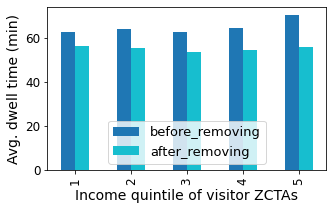

In [95]:
%%time
pd.concat([
(get_odX(city, True, out_hosp=False)
          .query('week == 200330')
          .merge(g.IMP_NAICS['category'], on='naics')
 .query('category == "Fast food/Takeout"')
          .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'),
                 left_on='poi_zip', right_index=True)
          .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                 left_on='home_zip', right_index=True)
          .groupby(['category', 'home_inc_q'])
          .agg({**{'med_dwell': np.mean}, **{x: sum for x in [
              'poi_visitors', 'visits4', 'visits5', 'tot_dwell4', 'tot_dwell5']}})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          .drop(columns=['tot_dwell4', 'tot_dwell5'])
          ['avg_dwell5'].reset_index()
 .drop(columns='category')
 .set_index('home_inc_q')
 .rename(columns={'avg_dwell5': 'before_removing'})
),
(get_odX(city, True, out_hosp=True)
          .query('week == 200330')
          .merge(g.IMP_NAICS['category'], on='naics')
 .query('category == "Fast food/Takeout"')
          .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'),
                 left_on='poi_zip', right_index=True)
          .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                 left_on='home_zip', right_index=True)
          .groupby(['category', 'home_inc_q'])
          .agg({**{'med_dwell': np.mean}, **{x: sum for x in [
              'poi_visitors', 'visits4', 'visits5', 'tot_dwell4', 'tot_dwell5']}})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          .drop(columns=['tot_dwell4', 'tot_dwell5'])
          ['avg_dwell5'].reset_index()
 .drop(columns='category')
 .set_index('home_inc_q')
 .rename(columns={'avg_dwell5': 'after_removing'})
)
], axis=1).plot.bar(cmap='tab10', figsize=(5, 3))
plt.legend(loc='lower center')
plt.ylabel('Avg. dwell time (min)')
plt.xlabel('Income quintile of visitor ZCTAs');

### By POI income

In [96]:
def dwell_by_naics_inc_on_date(city, date, measure='avg_dwell5',
                               imp_zips=True, out_hosp=True, plot=True):
    """
    Get the average dwell time on a specific date of different industries by
    income class of the POI zip.
    @param measure: <str> use one of these 3 measures to average dwell time:
        1. avg. of weekly median,
        2. avg. of 1st 4 bins,
        3. avg. of all bins with last bin = 240 min
    """
    # add the column for visits of dwell bin 5
    df = get_pat(city, imp_zips, out_hosp)
    # filter the data of the given date
    df = df[df['week'] == int(date.replace('-', '')[2:])]
    # get the POI income bin
    df = df.merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'), on='zip')
    # aggregate the dwell time measures
    df = (df.merge(g.IMP_NAICS['category'], on='naics')
          .groupby(['poi_inc_q', 'category'])
          .agg({'med_dwell': np.mean, 'visits5': sum, 'visits4': sum,
                'tot_dwell4': sum, 'tot_dwell5': sum})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          [measure].reset_index()
         )
    # plot the distribution
    if plot:
        p = sns.catplot(kind='bar', data=df, x='category', y=measure,
                        hue='poi_inc_q', palette='summer_r', aspect=1.8,
                        height=4)
        ax = p.axes[0, 0]
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('')
        ax.set_ylabel('Avg. dwell time (min)')
        ax.set_title(f'Avg. dwell time composition on {date} in {city.name}' +
                     '\nby income class of POIs across different industries')
    return df

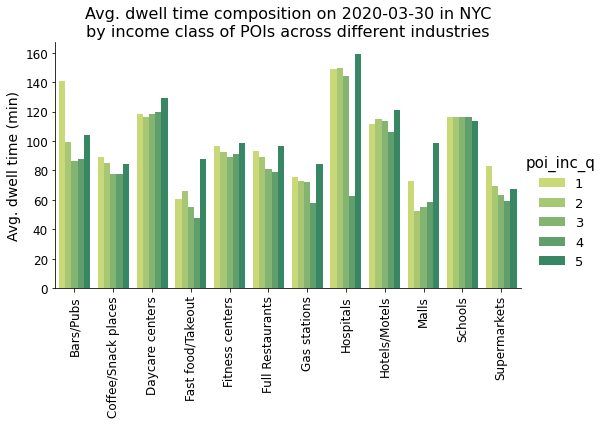

In [97]:
_ = dwell_by_naics_inc_on_date(nyc, '2020-03-30', 'avg_dwell5', True, out_hosp=False)

In [98]:
_.query('category == "Fast food/Takeout"').drop(columns=['category'])

,poi_inc_q,avg_dwell5
3,1,60.333120
15,2,65.939968
27,3,55.313410
39,4,47.859175
51,5,87.755383


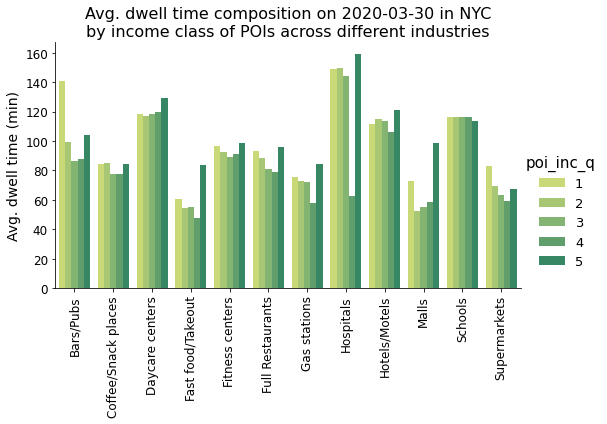

In [99]:
_ = dwell_by_naics_inc_on_date(nyc, '2020-03-30', 'avg_dwell5', True, out_hosp=True)

In [100]:
_.query('category == "Fast food/Takeout"').drop(columns=['category'])

,poi_inc_q,avg_dwell5
3,1,60.333120
15,2,54.317442
27,3,55.313410
39,4,47.859175
51,5,83.566028


### Of specific industry

In [101]:
def dwell_by_inc_of_naics(city, week, industry, imp_zips=True, out_hosp=True):
    target_naics = g.IMP_NAICS.query(f'category == "{industry}"').index[0]
    # filter the data
    df = (get_odX(city, imp_zips, out_hosp)
          .query(f'naics == {target_naics}')
          .query('week == ' + week.replace('-', '')[2:])
          .drop(columns=['week', 'naics'])
          .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'),
                 left_on='poi_zip', right_index=True)
          .groupby('poi_inc_q')
#           .groupby('home_inc_bin')
          .agg({**{'med_dwell': np.mean}, **{x: sum for x in [
              'poi_visitors', 'visits5', 'visits4', 'tot_dwell4',
              'tot_dwell5']}})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          .drop(columns=['tot_dwell4', 'tot_dwell5'])
         )
    return df

CPU times: user 1.34 s, sys: 558 ms, total: 1.9 s
Wall time: 1.89 s


<AxesSubplot:xlabel='poi_inc_q'>

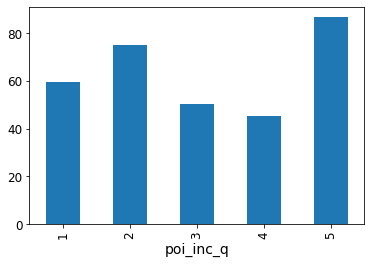

In [102]:
%%time
dwell_by_inc_of_naics(nyc, '2020-03-30', 'Fast food/Takeout', out_hosp=False
                      )[['poi_visitors', 'avg_dwell5']].avg_dwell5.plot.bar()

In [103]:
%%time
dwell_by_inc_of_naics(nyc, '2020-03-30', 'Fast food/Takeout', out_hosp=True
                      )[['poi_visitors', 'avg_dwell5']]

CPU times: user 1.31 s, sys: 557 ms, total: 1.86 s
Wall time: 1.87 s


,poi_visitors,avg_dwell5
poi_inc_q,,
1,145659.0,59.622185
2,125452.0,51.306499
3,87241.0,50.178614
4,103650.0,45.432088
5,67182.0,74.062261


In [104]:
def od_dwell_by_naics_inc_on_date(city, week, dwell_var='avg_dwell5',
                                  inc_q_var='home_inc_q', imp_zips=True,
                                  out_hosp=True, plot=True):
    """
    Get the average dwell time on a specific date of different industries by
    income class of the POI zip but use the `city.od` table instead of `city.pat`.
    @param measure: <str> use one of these 3 measures to average dwell time:
        1. avg. of weekly median,
        2. avg. of 1st 4 bins,
        3. avg. of all bins with last bin = 240 min
    """
#     imp_pois = (city.pois.merge(g.IMP_NAICS, on='naics')
#                 [['poi_id', 'zip', 'category']])
    df = (get_odX(city, imp_zips, out_hosp)
          .query('week == ' + week.replace('-', '')[2:])
          .merge(g.IMP_NAICS['category'], on='naics')
          .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'),
                 left_on='poi_zip', right_index=True)
          .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                 left_on='home_zip', right_index=True)
          .groupby(['category', 'home_inc_q'])
#           .groupby(['category', 'poi_inc_q'])
          .agg({**{'med_dwell': np.mean}, **{x: sum for x in [
              'poi_visitors', 'visits4', 'visits5', 'tot_dwell4', 'tot_dwell5']}})
          .assign(avg_dwell4 = lambda x: x['tot_dwell4']/x['visits4'],
                  avg_dwell5 = lambda x: x['tot_dwell5']/x['visits5'])
          .drop(columns=['tot_dwell4', 'tot_dwell5'])
          [dwell_var].reset_index()
         )
    # plot the distribution
    if plot:
        p = sns.catplot(kind='bar', data=df, x='category', y=dwell_var,
                        hue=inc_q_var, palette=g.CMAPS['income_classes'],
                        aspect=1.8, height=4)
        ax = p.axes[0, 0]
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel('')
        ax.set_ylabel('Avg. dwell time (min)')
        if inc_q_var == 'poi_inc_q': label = 'POIs'
        elif inc_q_var == 'home_inc_q': label = 'home zips'
        else: label = ''
        ax.set_title(f'Avg. dwell time composition on {week} in {city.name}' +
                     f'\nby income class of {label} across different industries')
    return df

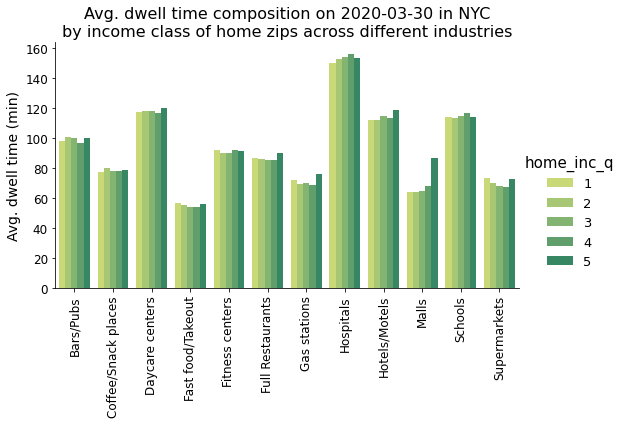

In [105]:
_1 = od_dwell_by_naics_inc_on_date(nyc, '2020-03-30', 'avg_dwell5')

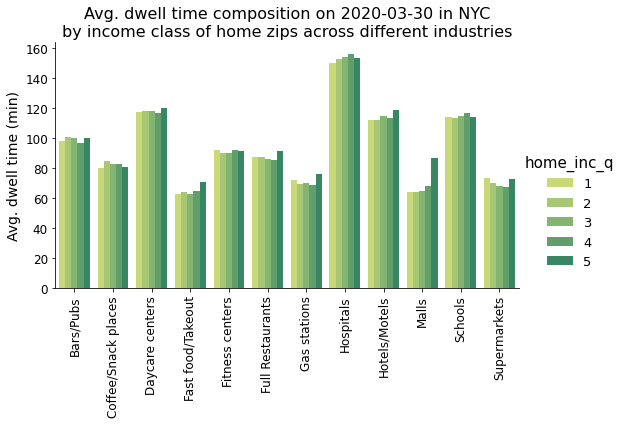

In [106]:
_2 = od_dwell_by_naics_inc_on_date(nyc, '2020-03-30', 'avg_dwell5', out_hosp=False)

In [107]:
pd.concat([_2.query('category == "Fast food/Takeout"')
           .set_index('home_inc_q')['avg_dwell5'].rename('before'),
           _1.query('category == "Fast food/Takeout"')
           .set_index('home_inc_q')['avg_dwell5'].rename('after')
           ], axis=1)

,before,after
home_inc_q,,
1,62.677286,56.467545
2,64.268502,55.452168
3,62.924189,53.877509
4,64.483579,54.404006
5,70.584671,56.116437


## Exposure (<4 hr)

## Aggregate expsoure

### By POI zip income
Using patterns, not pat_od

In [108]:
def get_exp_by_poi_inc(city, exp_var='cdi', nbins=5,
                        imp_zips=True, plot=True):
    """
    Get the weekly trend of average exposure over income class of home
    visitors.
    @param var: <str> exposure variable to be used
    (column name must be in `city.od`)
    """
    res = (get_pat(city, imp_zips)
           .merge(city.acs_zip['hh_inc_q'].rename('poi_inc_q'), on='zip')
           .groupby(['poi_inc_q', 'week'])
           [['tot_cdi', 'exp_visits']].sum()
           .assign(cdi = lambda x: x['tot_cdi']/x['exp_visits'])
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby(['poi_inc_q']), colors):
            (df[exp_var]).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        plt.ylabel('$cdi$ (min-persons/ft)')
        plt.legend()
        plt.title(f'Weekly avg. $cdi$ ({nbins} bins) by income\n' +
                  'quintile of home zip in ' + city.name);
    return res

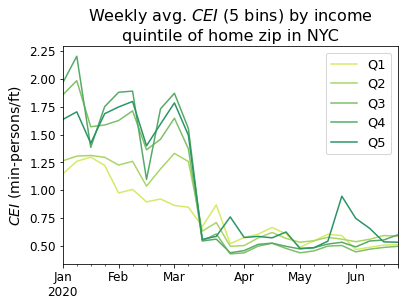

In [109]:
_ = get_exp_by_poi_inc(nyc)

### By home zip income 

In [110]:
def get_exp_by_home_inc(city, exp_var='cdi', nbins=5,
                        imp_zips=True, plot=False):
    """
    Get the weekly trend of average exposure over income class of home
    visitors.
    @param var: <str> exposure variable to be used
    (column name must be in `city.od`)
    """
    res = (get_odX(city, imp_zips)
           .merge(city.acs_zip['hh_inc_q'].rename('home_inc_q'),
                  left_on='home_zip', right_index=True)
           .groupby(['week', 'poi_id', 'home_inc_q'])
           .agg({exp_var: 'first', 'home_visitors': sum})
           .assign(tot_exp = lambda x: x[exp_var]*x['home_visitors'])
           .reset_index()
          )
    # calculate the total home visitors of each POI
    tot_vis_by_poi = (res.groupby(['week', 'poi_id'])
                      ['home_visitors'].sum().rename('tot_home_visitors'))
    # now distribute the POI total exposure into its income class components
    # in proportion of the home visitors in its income classes
    res = (res
           .merge(tot_vis_by_poi, on=('week', 'poi_id'))
           .astype({'tot_exp': float, 'home_visitors': int,
                    'tot_home_visitors': float})
           .assign(tot_exp_inc = lambda x:
                   x['tot_exp']*x['home_visitors']/x['tot_home_visitors'])
           .drop(columns=['tot_exp'])
           .rename(columns={'tot_exp_inc': 'tot_'+exp_var})
           .groupby(['week', 'home_inc_q'])
           .sum()
           .assign(avg_exp = lambda x: x['tot_'+exp_var]/x['home_visitors'])
           .rename(columns={'avg_exp': 'avg_'+exp_var})
           .drop(columns=['tot_'+exp_var, 'tot_home_visitors'])
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
           .set_index('week')
          )
    if plot:
        fig, ax = plt.subplots()
        colors = sns.color_palette(g.CMAPS['income_classes'], g.INC_NBINS)
        for (bin_, df), col in zip(res.groupby(['home_inc_q']), colors):
            (df['avg_'+exp_var]).plot(ax=ax, color=col, label=f'Q{bin_}')
        plt.xlabel('')
        plt.ylabel('$cdi$ (min-persons/ft)')
        plt.legend()
        plt.title(f'Weekly avg. $cdi$ ({nbins} bins) by income\n' +
                  'quintile of home zip in ' + city.name);
    return res

CPU times: user 17.6 s, sys: 3.7 s, total: 21.3 s
Wall time: 21.3 s


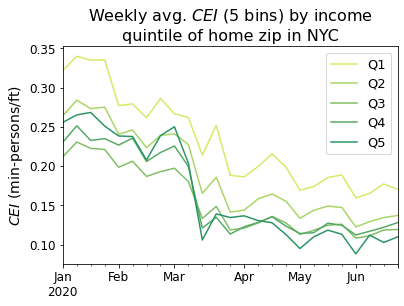

In [111]:
%time _ = get_exp_by_home_inc(nyc, plot=True)

### By home zip

In [112]:
def get_exp_by_home_zip(city, imp_zips=True, nbins=4):
    """
    Get the weekly trend of average exposure of each zip code of home
    visitors.
    """
    odX = (get_odX(city, imp_zips)
           .assign(tot_exp = lambda x: x['cdi']*x['home_visitors'])
           [['poi_id', 'week', 'home_zip', 'home_visitors', 'tot_exp']]
          )
    # calculate the total home visitors of each POI
    tot_vis_by_poi = (odX.groupby(['week', 'poi_id'])
                      ['home_visitors'].sum().rename('tot_home_visitors'))
    # now distribute the POI total exposure into its income class components
    # in proportion of the home visitors in its income classes
    res = (odX
           .merge(tot_vis_by_poi, on=('week', 'poi_id'))
           .astype({'tot_exp': float, 'home_visitors': int,
                    'tot_home_visitors': float})
           .assign(zip_exp = lambda x:
                   x['tot_exp']*x['home_visitors']/x['tot_home_visitors'])
           .groupby(['week', 'home_zip'])
           [['tot_exp', 'home_visitors']]
           .sum()
           .assign(avg_exp = lambda x: x['tot_exp']/x['home_visitors'])
           .reset_index()
           .assign(week = lambda x: g.int2date(x['week']))
          )
    return res

In [113]:
%%time
nyc.cdi_zip_wk = get_exp_by_home_zip(nyc, True)
peek(nyc.cdi_zip_wk)

Shape: (4275, 5), Memory: 0.163 MB
CPU times: user 5.56 s, sys: 2.33 s, total: 7.89 s
Wall time: 7.91 s


,week,home_zip,tot_exp,home_visitors,avg_exp
0,2020-01-06,10001,43208.038902,46546,0.928287
1,2020-01-06,10002,52313.959815,60897,0.859056
2,2020-01-06,10003,30811.283980,36247,0.850037


In [114]:
%time chi.cdi_zip_wk = get_exp_by_home_zip(chi, True)

CPU times: user 4.14 s, sys: 2.67 s, total: 6.81 s
Wall time: 7.86 s


## Cases vs exposure (snapshot)

In [115]:
def plot_cases_vs_mob_by_zip(city, week, xvar='tot_cdi', yvar='new_cases',
                             plot=True, plot_kde=True, regress=True, dpi=70,
                             xmin=0, xmax=None, ymin=0, ymax=None):
    """
    Scatterplot of cases vs mobility measure on a given weekdate where each
    point represents a zip code which is colored by its income level.
    """
    # agg the new cases by zip & week
    cases = city.cases.groupby(['zip', 'week'])['new_cases'].sum().reset_index()
    # fetch the cdi by zip & week
    cdi_zip = (city.cdi_zip_wk
               .rename(columns={'avg_exp': 'avg_cdi', 'home_zip': 'zip'}))
    # calc. total cdi
    res = (cdi_zip.assign(tot_cdi = lambda x: x['avg_cdi'] * x['home_visitors']))
    # join with the cases data
    res = res.merge(cases, on=('week', 'zip'))
    # filter the data on the given date
    res = res[res['week'] == g.str2date(week)].drop(columns='week')
    # get the income bin of the home zip
    res = res.merge((city.acs_zip[['tot_pop', 'hh_inc_q']]
                     .rename(columns={'hh_inc_q': 'home_inc_q'})), on='zip')
    # get the values per unit population
    res['tot_cdi_per_pop'] = res['tot_cdi']/(res['tot_pop']/1000)
    res['cases_per_pop'] = res['new_cases']/(res['tot_pop']/1000)
    
    if plot:
        fig = plt.figure(figsize=(8, 3.5), dpi=dpi)
        gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])
        ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
        twin = ax1.twinx()
        colors = g.COLORS['income_classes5']
        markers = ['o', '^', '*', 'P', 'd']        
        
        # 1st axes: cases vs total exposure scatterplot
        for i, (bin_, df) in enumerate(res.groupby('home_inc_q')):
            X, Y = df[xvar], df[yvar]
            if xvar == 'home_visitors':
                X = X/1000
            if regress:
                model = LinearRegression(fit_intercept=False)
                model.fit(X.values.reshape((-1,1)), Y.values)
                m = model.coef_[0]
                ax1.plot(X.values, m*X.values, color=colors[i], lw=0.5)
            if plot_kde:
                X.plot.kde(ax=twin, color=colors[i], lw=1, ls='--')
            pts = ax1.scatter(X, Y, color=colors[i], label=f'Q{bin_}', s=30,
                              marker=markers[i])
        ax1.set_xlim(xmin, xmax)
        ax1.set_ylim(ymin, ymax)
        xlabels = {'tot_cdi': 'Total cdi (min/ft)',
                   'tot_cdi_per_pop': 'Total cdi (min/ft) per 1000 residents',
                   'home_visitors': 'Total visitors (k)',
                   'avg_cdi': 'Avg. cdi (min/ft)'}
        ylabels ={'new_cases': 'New weekly cases',
                  'cases_per_pop': 'Weekly case rate\n(per 1000 residents)'}
        ytitle = 'Case rate' if yvar == 'cases_per_pop' else 'Cases'
        titles = {'tot_cdi': f'{ytitle} vs total exposure',
                  'tot_cdi_per_pop': f'{ytitle} vs total exposure per unit population',
                  'home_visitors': f'{ytitle} vs total no. of visitors',
                  'avg_cdi': f'{ytitle} vs avg. cdi'}
        ax1.set_xlabel(xlabels[xvar])
        ax1.set_ylabel(ylabels[yvar])
        wk = g.str2date(week)
        ax1.set_title('{}\n in {} during {} - {}'.format(
            titles[xvar], city.name, wk.strftime("%d %b"),
            (wk + pd.DateOffset(days=6)).strftime("%d %b")))
        ax1.legend(fontsize=10)
        
        # 2nd axes: total visitors by income class
        visitors = res.groupby('home_inc_q')['home_visitors'].sum()/1e3
        visitors.plot.barh(ax=ax2, x='home_inc_q', y='home_visitors', color=colors)
        ax2.set_xlabel('Total home visitors (k)')
        ax2.set_ylabel('Income class')
        ax2.set_title('Visitor income\ndistribution')
        for i, v in enumerate(visitors):
            ax2.text(20, i-0.1, f'{v/visitors.sum()*100:.2f}%')
        plt.tight_layout()
        
    return res

In [116]:
xnyc = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', plot=False)
peek(xnyc)

Shape: (170, 10), Memory: 0.013 MB


,zip,tot_exp,home_visitors,avg_cei,tot_cei,new_cases,tot_pop,home_inc_q,tot_cei_per_pop,cases_per_pop
0,10001,2814.635714,7595,0.370591,2814.635714,53.0,43898,5,64.117630,1.207344
1,10002,3713.154558,10552,0.351891,3713.154558,178.0,82015,2,45.274091,2.170335
2,10003,1387.353575,3864,0.359046,1387.353575,69.0,72006,5,19.267194,0.958253


In [117]:
for q, df in xnyc.groupby('home_inc_q'):
    model = sm.OLS(df['new_cases'], df['tot_cdi']).fit()
    print('/\\'*50, '\n\n', q, model.summary())

/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\ 

 1                                  OLS Regression Results                                
Dep. Variable:              new_cases   R-squared (uncentered):                   0.842
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                              186.2
Date:                Mon, 29 Mar 2021   Prob (F-statistic):                    1.41e-15
Time:                        19:41:24   Log-Likelihood:                         -235.83
No. Observations:                  36   AIC:                                      473.7
Df Residuals:                      35   BIC:                                      475.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
              

### Total cdi

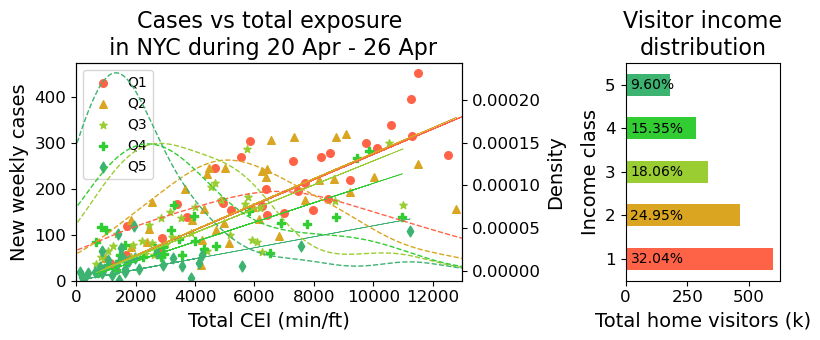

In [118]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-20', 'tot_cdi', xmax=13000, dpi=100)

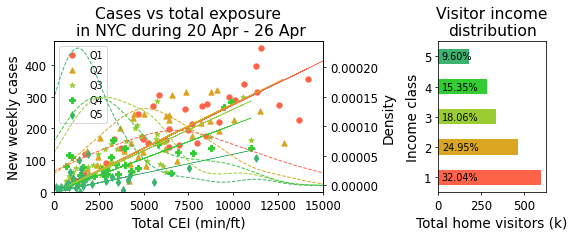

In [119]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-20', 'tot_cdi', xmax=15000)

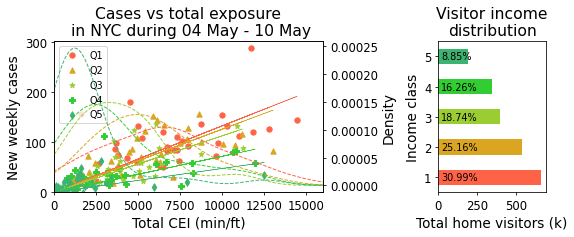

In [120]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-05-04', 'tot_cdi', xmax=16000)

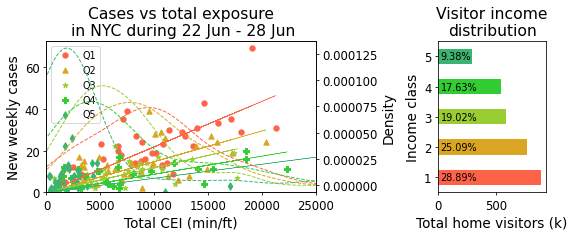

In [121]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-06-22', 'tot_cdi', xmax=25000)

### Total cdi per unit population

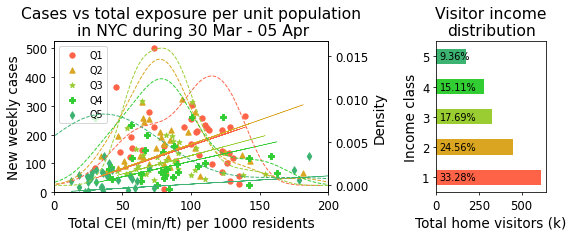

In [122]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'tot_cdi_per_pop', xmax=200)

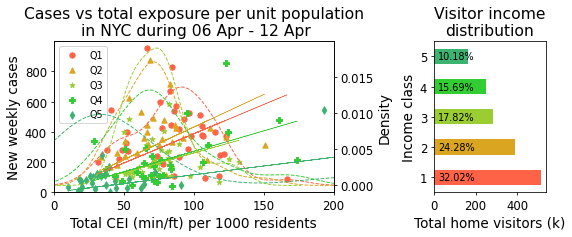

In [123]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'tot_cdi_per_pop', xmax=200)

### Total cdi & cases per unit population

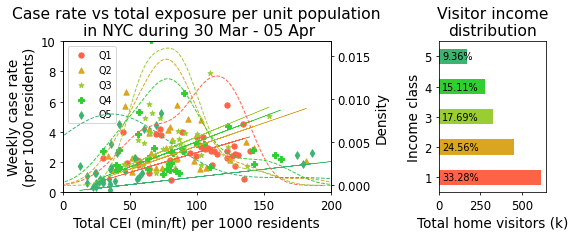

In [124]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'tot_cdi_per_pop', 'cases_per_pop', xmax=200, ymax=10)

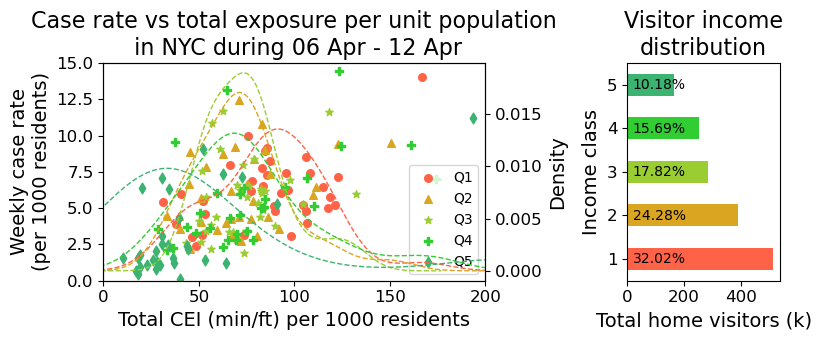

In [125]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'tot_cdi_per_pop', 'cases_per_pop',
                             regress=False, xmax=200, ymax=15, dpi=100)

### Avg cdi

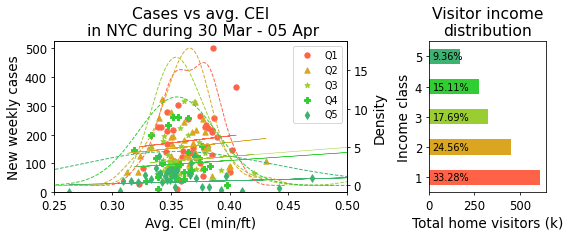

In [126]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'avg_cdi', xmin=0.25, xmax=0.5)

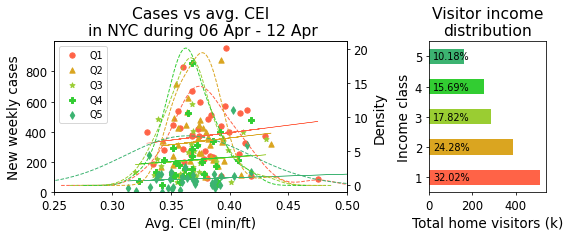

In [127]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'avg_cdi', xmin=0.25, xmax=0.5)

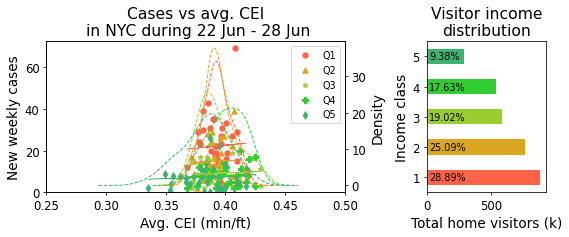

In [128]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-06-22', 'avg_cdi', xmin=0.25, xmax=0.5)

### Total visitors

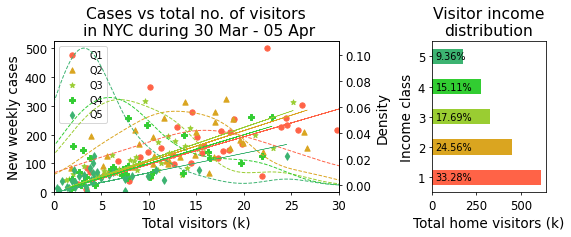

In [129]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-03-30', 'home_visitors', xmax=30)

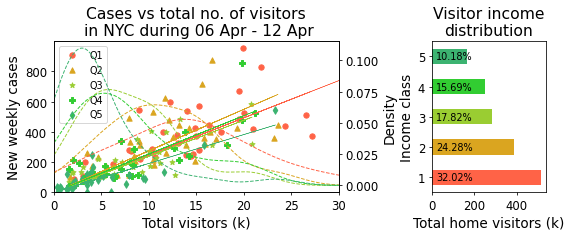

In [130]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-04-06', 'home_visitors', xmax=30)

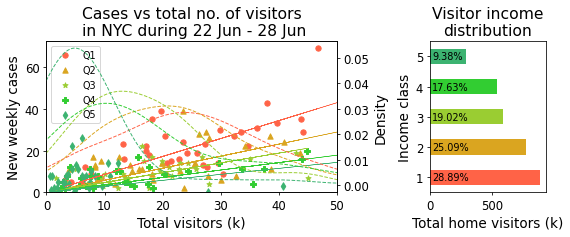

In [131]:
_ = plot_cases_vs_mob_by_zip(nyc, '2020-06-22', 'home_visitors', xmax=50)

KeyError: 'week'

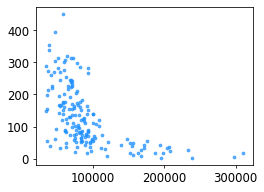

In [132]:
def plot_inc_vs_cdi_cases(cities, week, yvar, title=None, ylabel=None):
    """
    Scatterplot of cases vs mobility measure on a given weekdate where each
    point represents a zip code which is colored by its income level.
    """
    fig, ax = plt.subplots(figsize=(4, 3), dpi=70)
    for city in cities:
        # agg the new cases by zip & week
        cases = city.cases.groupby(['zip', 'week'])['new_cases'].sum().reset_index()
        # fetch the cdi by zip & week
        cdi_zip = (city.cdi_zip_wk
                   .rename(columns={'avg_exp': 'avg_cdi', 'home_zip': 'zip'}))
        # calc. total cdi
        res = (cdi_zip.assign(tot_cdi = lambda x: x['avg_cdi'] * x['home_visitors']))
        # join with the cases data
        res = res.merge(cases, on=('week', 'zip'))
        # filter the data on the given date
        res = res[res['week'] == g.str2date(week)].drop(columns='week')
        # get the zip census info
        res = res.merge(city.acs_zip[['tot_pop', 'hh_inc_q', 'avg_hh_income']],
                        on='zip')
        # plot
        ax.scatter(res['avg_hh_income'], res[yvar], alpha=0.7,
                   color=city.color, s=8, label=city.name)
    ax.xaxis.set_major_formatter(mpl.ticker.EngFormatter())
    ax.yaxis.set_major_formatter(mpl.ticker.EngFormatter())
    ax.set_title(title)
    ax.set_xlabel('Avg. household income ($) (2017)', fontsize=15)
    ax.set_ylabel(ylabel)
    ax.legend()
    plt.savefig(f'img/income vs {yvar}.png', dpi=100, bbox_inches='tight')

plot_inc_vs_cdi_cases(cities, '2020-04-20', 'new_cases', 'New weekly cases', 'No. of cases')
plot_inc_vs_cdi_cases(cities, '2020-04-20', 'tot_cdi', 'Total CDI', 'CDI (min/ft)')

In [138]:
vars(il).keys()

dict_keys(['key', 'name_', 'name', 'dir', 'counties', 'events', 'full_name', 'color', 'shp_cbg', 'shp_cnty', 'pois', 'rt', 'acs', 'pat', 'od_zip', 'sd', 'exp', 'exp_daily', 'cases', 'imp_zips', 'shp_zip', 'acs_zip', 'in_hosp_pois', 'odX'])

In [141]:
il.rt = g.load_rt(il)
peek(il.rt)

Shape: (20706, 9), Memory: 1.422 MB


,cnty,date,Rt,Rt_upr,Rt_lwr,tot_cases,new_cases,tot_deaths,new_deaths
0,17001,2020-03-19,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1,17001,2020-03-20,NaN,NaN,NaN,1.0,1.0,0.0,0.0
2,17001,2020-03-21,NaN,NaN,NaN,1.0,0.0,0.0,0.0


In [142]:
il.pois

,naics,lat,lon,zip,cbg,is_synthetic,includes_parking_lot,area_sqft,cnty
poi_id,,,,,,,,,
4260103,541940,39.957573,-91.370560,62301,170010001001,False,False,6915,17001
4364791,812112,39.937073,-91.395432,62301,170010005002,False,False,1621,17001
952640,811411,39.926044,-91.344276,62305,170010011001,False,False,7333,17001
1211179,441110,39.947418,-91.376755,62301,170010001003,False,True,62312,17001
311762,811192,39.944347,-91.377052,62301,170010001003,False,False,2274,17001
...,...,...,...,...,...,...,...,...,...
3383133,441110,40.794426,-89.198891,61561,172030303001,False,True,40972,17203
3077429,812210,40.717201,-89.273376,61530,172030306014,False,False,900,17203
698482,722513,40.737289,-89.028664,61738,172030307001,False,False,3158,17203


In [179]:
il_exp = (
    il.exp_daily.reset_index()
    .pipe(lambda x: x[(x.date >= 200301)])
    .merge(il.pois['cnty'].reset_index(), on='poi_id')
    .assign(tot_cdi = lambda x: x['cdi']*x['exp_visits'])
    .groupby(['cnty', 'date'])[['exp_visits', 'tot_cdi']].sum()
    .reset_index()
    .assign(avg_cdi = lambda x: x['tot_cdi']/x['exp_visits'],
            date = lambda x: g.int2date(x['date']))
)
peek(il_exp)

Shape: (12240, 5), Memory: 0.420 MB


,cnty,date,exp_visits,tot_cei,avg_cei
0,17001,2020-03-01,3300.0,3148.707520,0.954154
1,17001,2020-03-02,4864.0,8332.759766,1.713150
2,17001,2020-03-03,5030.0,8539.894531,1.697792


In [178]:
il_sd = (
    il.sd.reset_index()
    .assign(cnty = lambda x: x['cbg']//int(1e7))
    .groupby(['cnty', 'date'])
    [['tot_dev', 'dev_home', 'time_home']].sum()
    .reset_index()
    .pipe(lambda x: x[(x.date >= g.int2date(200301))])
    .assign(prop_home = lambda x: x['dev_home']/x['tot_dev'])
)
peek(il_sd)

Shape: (12444, 6), Memory: 0.665 MB


,cnty,date,tot_dev,dev_home,time_home,prop_home
60,17001,2020-03-01,5170.0,1461.0,686.766667,0.282592
61,17001,2020-03-02,5236.0,1210.0,609.250000,0.231092
62,17001,2020-03-03,5303.0,802.0,553.966667,0.151235


In [215]:
il_acs = (
    il.acs.assign(cnty = lambda x: x.index//(int(1e7)))
    [['cnty', 'tot_pop', 'frac_poor', 'frac_low_edu', 'frac_old',
      'frac_female', 'frac_black', 'frac_transit', 'avg_income']]
    .set_index('cnty'))
il_tot_pop = il_acs.pop('tot_pop')
il_acs = il_acs.apply(lambda x: x * il_tot_pop.values)
il_tot_pop = il_tot_pop.groupby('cnty').sum()
il_acs = (il_acs.groupby('cnty').sum()
          .apply(lambda x: x / il_tot_pop.values))
il_acs.insert(0, 'tot_pop', il_tot_pop)
il_acs = il_acs.reset_index()
peek(il_acs)

Shape: (102, 9), Memory: 0.007 MB


,cnty,tot_pop,frac_poor,frac_low_edu,frac_old,frac_female,frac_black,frac_transit,avg_income
0,17001,66949,0.536339,0.776471,0.186142,0.512121,0.037954,0.006333,26052.637709
1,17003,7051,0.587977,0.913336,0.188342,0.509006,0.338675,0.011848,16066.775351
2,17005,17137,0.551397,0.806048,0.167824,0.490226,0.052810,0.014015,23660.233005


In [168]:
all_cases = pd.read_csv('/Volumes/Seagate_RV/Research_Data/SG_Covid19/health_cases/time_series_covid19_confirmed_US.csv')
peek(all_cases)

Shape: (3340, 214), Memory: 6.529 MB


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,368,375,389,397,411,411,411,418,418,449
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,45,46,46,46,47,47,48,48,49,49


In [223]:
il_cases = (
    all_cases[all_cases.FIPS.isin(il_acs.cnty)]
    .astype({'FIPS': int})
    .set_index('FIPS').rename_axis('cnty')
    .filter(regex='^[0-9]')
    .reset_index()
    .melt(id_vars=['cnty'], var_name='date', value_name='cases')
    .assign(date = lambda x: pd.to_datetime(x['date']))
    .pipe(lambda x: x[(x.date <= g.int2date(200701))])
)
il_cases = pd.concat([
    il_cases, il_cases.groupby('cnty')['cases'].shift().rename('cases_prev')
], axis=1)
peek(il_cases)

Shape: (16524, 4), Memory: 0.630 MB


,cnty,date,cases,cases_prev
0,17001,2020-01-22,0,NaN
1,17003,2020-01-22,0,NaN
2,17005,2020-01-22,0,NaN


In [226]:
il_modelX = (
    il_exp.merge(il_sd, on=['cnty', 'date'])
    .merge(il_acs, on='cnty')
    .merge(il_cases, on=['cnty', 'date'])
    .rename(columns={'avg_income': 'income'})
)
peek(il_modelX)

Shape: (12240, 19), Memory: 1.774 MB


,cnty,date,exp_visits,tot_cei,avg_cei,tot_dev,dev_home,time_home,prop_home,tot_pop,frac_poor,frac_low_edu,frac_old,frac_female,frac_black,frac_transit,income,cases,cases_prev
0,17001,2020-03-01,3300.0,3148.707520,0.954154,5170.0,1461.0,686.766667,0.282592,66949,0.536339,0.776471,0.186142,0.512121,0.037954,0.006333,26052.637709,0,0.0
1,17001,2020-03-02,4864.0,8332.759766,1.713150,5236.0,1210.0,609.250000,0.231092,66949,0.536339,0.776471,0.186142,0.512121,0.037954,0.006333,26052.637709,0,0.0
2,17001,2020-03-03,5030.0,8539.894531,1.697792,5303.0,802.0,553.966667,0.151235,66949,0.536339,0.776471,0.186142,0.512121,0.037954,0.006333,26052.637709,0,0.0


In [227]:
il_modelX.to_csv(il.dir+'/zip_modelX.csv', index=False)

---
# Modeling

## Cases vs exposure
Level: Zip-daily

### Get the data

In [149]:
def get_modelX(city, xvar='tot_cdi', lag=7, start_date='2020-03-01', dropna=True):
    """
    Prepare the dataset for training the SEM model as shown in the PNAS paper
    https://www.pnas.org/content/117/44/27087
    """
    # get the zip-daily level exposure data
    res = (
        city.exp_daily
        .reset_index(['poi_id', 'date'])
        .pipe(lambda x: x[x['date'] >= g.strdate2int(start_date)])
        .merge(city.pois['zip'], on='poi_id')
        .merge(city.imp_zips)
        .assign(tot_cdi = lambda x: x['cdi']*x['exp_visits'])
        .groupby(['zip', 'date'])
        [['exp_visits', 'tot_cdi']].sum()
        .assign(avg_cdi = lambda x: x['tot_cdi']/x['exp_visits'])
        .reset_index()
        .assign(date = lambda x: g.int2date(x['date']))
    )
    # add the social distancing info
    sd = (g.map_cbg_zip(city.sd.reset_index())
          .assign(tot_time_home = lambda x: x['time_home']*x['tot_dev'])
          .drop(columns=['cbg', 'time_home'])
          .groupby(['zip', 'date']).sum()
          .reset_index()
          .merge(city.imp_zips, on='zip')
          .assign(prop_home = lambda x: x['dev_home']/(x['tot_dev']+1),
                  time_home = lambda x: x['tot_time_home']/(x['tot_dev']+1))
          .drop(columns=['tot_time_home', 'dev_home'])
          .astype({'tot_dev': np.int32})
         )
    res = res.merge(sd, on=('zip', 'date'))
    
    # add census data
    res = (res.merge(city.acs_zip[['avg_hh_income'] + g.VUL_VARS], on='zip')
           .assign(income = lambda x: x['avg_hh_income']/1e3)
           .drop(columns=['avg_hh_income'])
          )
    # add cases data
    res = (res.merge(city.cases
                     .rename(columns={'new_cases': 'cases', 'new_tests': 'tests'})
                     [['zip', 'date', 'cases', 'tests']],
                     on=('zip', 'date'), how='left')
           .pipe(lambda x: x[x['date'] <= g.int2date(200628)])
           .sort_values('date')
           .assign(cases = lambda x: x['cases'].fillna(0),
                   tests = lambda x: x['tests'].fillna(0))
    )
    # get the lag adjusted measures
    res = pd.concat([
        res, res.groupby('zip')['cases'].shift().rename('cases_prev'),
        res.groupby('zip')['tests'].shift().rename('tests_prev'),
        res.groupby('zip')[xvar].shift(lag).rename(xvar+'_lag'),
        res.groupby('zip')[xvar].shift(lag+1).rename(xvar+'_lag_prev')
    ], axis=1)
    res = res.set_index(['zip', 'date']).sort_index()
    
    # make sure all values are non-negative
    res = res[res >= 0].reset_index()
    # add the log columns
    xyvars = ['cases', 'cases_prev', 'tests', 'tests_prev', 'income',
              xvar+'_lag', xvar+'_lag_prev']
    for var in xyvars:
        res['log_'+var] = np.log(1 + res[var])
    if dropna:
        res = res.dropna()
    
    return res

# get_modelX(nyc)

In [164]:
nyc.modelX.columns

Index(['zip', 'date', 'exp_visits', 'tot_cei', 'avg_cei', 'tot_dev',
       'prop_home', 'time_home', 'frac_poor', 'frac_low_edu', 'frac_old',
       'frac_female', 'frac_black', 'frac_transit', 'income', 'cases', 'tests',
       'cases_prev', 'tests_prev', 'tot_cei_lag', 'tot_cei_lag_prev',
       'log_cases', 'log_cases_prev', 'log_tests', 'log_tests_prev',
       'log_income', 'log_tot_cei_lag', 'log_tot_cei_lag_prev'],
      dtype='object')

In [150]:
%%time
nyc.modelX = get_modelX(nyc, dropna=False)
peek(nyc.modelX)

Shape: (20401, 28), Memory: 3.697 MB
CPU times: user 1.61 s, sys: 720 ms, total: 2.33 s
Wall time: 4.76 s


,zip,date,exp_visits,tot_cei,avg_cei,tot_dev,prop_home,time_home,frac_poor,frac_low_edu,...,tests_prev,tot_cei_lag,tot_cei_lag_prev,log_cases,log_cases_prev,log_tests,log_tests_prev,log_income,log_tot_cei_lag,log_tot_cei_lag_prev
0,10001,2020-03-01,7659,6333.294434,0.826909,1957,0.276813,6.498374,0.532339,0.278937,...,NaN,NaN,NaN,0.0,NaN,0.0,NaN,5.153979,NaN,NaN
1,10001,2020-03-02,13187,15049.003906,1.141200,2047,0.246582,6.153621,0.532339,0.278937,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,5.153979,NaN,NaN
2,10001,2020-03-03,13991,16930.734375,1.210116,2168,0.242508,5.387782,0.532339,0.278937,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,5.153979,NaN,NaN


In [ ]:
chi.modelX = get_modelX(chi, dropna=False)

### Visualize

In [ ]:
(nyc.cases.groupby('date')['new_cases'].sum()
.pipe(lambda x: x[(x.index > g.int2date(200402)) & (x.index <= g.int2date(200628))])
# .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630))
plt.xticks(rotation=90);

In [ ]:
(nyc.modelX.groupby('date')['cases'].sum()
 .pipe(lambda x: x[x.index >= g.int2date(200402)])
#  .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630));

In [ ]:
(nyc.cases.groupby('date')['new_cases'].sum()
.pipe(lambda x: x[(x.index > g.int2date(200402)) & (x.index <= g.int2date(200628))])
# .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630))
plt.xticks(rotation=90);

In [ ]:
(chi.modelX.groupby('date')['tests'].sum()
 .pipe(lambda x: x[x.index >= g.int2date(200402)])
#  .rolling(7).mean()
 .plot())
plt.xlim(g.int2date(200401), g.int2date(200630));

### Export it

In [ ]:
nyc.modelX.dropna().to_csv(nyc.dir + '/zip_modelX.csv', index=False)

In [ ]:
chi.modelX.dropna().to_csv(chi.dir + '/zip_modelX.csv', index=False)

## Visualize

In [ ]:
%%time
def fig_study_area_horz(date='2020-04-20', dpi=70):
    date = g.str2date(date)
    last_week = [date - pd.DateOffset(days=x) for x in range(7)]
    fig = plt.figure(figsize=(15, 5), dpi=dpi)
    gs = mpl.gridspec.GridSpec(1, 4, width_ratios=[1.6, 1, 1.6, 1])
    
    def plot_colorbar(ax, data, cmap, frac=0.03):
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(
            vmin=data.min(), vmax=data.max())); sm._A = []
        cbar = fig.colorbar(sm, ax=ax, fraction=frac, pad=0.04, aspect=30)
    
    for i, c in enumerate([nyc, chi]):
        ax0 = plt.subplot(gs[0, i])
        ax1 = plt.subplot(gs[0, i+2])

        # plot cases of the last week
        cases = gp.GeoDataFrame(
            c.cases.pipe(lambda x: x[x['date'].isin(last_week)])
            [['zip', 'cum_cases']].merge(c.shp_zip))
        min_cases, max_cases = cases['cum_cases'].min(), cases['cum_cases'].max()
        cases.plot(column='cum_cases', cmap='inferno_r', ax=ax0)
        ax0.set_title('{}\nTotal cases'.format(c.name))
        plot_colorbar(ax0, cases['cum_cases'], 'inferno_r', frac=0.03 if c==nyc else 0.048)

        # plot exposure
        exp = gp.GeoDataFrame(
#             (c.modelX.reset_index()
#             .pipe(lambda x: x[x['date'] <= date])
#             .groupby('zip')['tot_cdi'].sum()/1e5.reset_index()
            c.cdi_zip_wk.pipe(lambda x: x[x.week == date])
            .rename(columns={'home_zip': 'zip', 'tot_exp': 'tot_cdi'})
            .merge(c.shp_zip))
        min_exp, max_exp = exp['tot_cdi'].min(), exp['tot_cdi'].max()
        exp.plot(column='tot_cdi', cmap='plasma_r', ax=ax1)
        ax1.set_title('{}\nTotal cdi (min/ft)'.format(c.name))
        plot_colorbar(ax1, exp['tot_cdi'], 'plasma_r', frac=0.03 if c==nyc else 0.048)
        
        # plot the centroids
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            inc_colors = {i+1: g.COLORS['income_classes5'][i] for i in range(5)}
            centroids = (c.shp_zip.merge(c.acs_zip['hh_inc_q'], on='zip')
                         .assign(centroid = lambda x: x['geometry']
                                 .to_crs(epsg=4269).centroid,
                                 color = lambda x: x['hh_inc_q'].map(inc_colors))
                         .drop(columns=['geometry'])
                         .rename(columns={'centroid': 'geometry'}))
        for ax_ in [ax0, ax1]:
            centroids.plot(ax=ax_, color=centroids['color'], markersize=5)
            ax_.set_xticks([])
            ax_.set_yticks([])
    plt.tight_layout()
    
fig_study_area_horz()

In [ ]:
%%time
def fig_exp_by_nacis(plot=True, start='2020-02-01', dpi=70):
    if plot:
        nrow, ncol = 3, 4
        fig, axs = plt.subplots(nrow, ncol, figsize=(13, 7), dpi=dpi,
                                sharex=True, sharey=False)
    daily_exp = pd.DataFrame()
    for c in [nyc, chi]:
        res = (c.exp_daily.reset_index()
               .assign(tot_cdi = lambda x: x['cdi']*x['exp_visits'])
               .merge(c.pois['naics'], on='poi_id')
               .merge(g.IMP_NAICS['category'], on='naics', how='left')
               .replace(np.nan, 'Others')
               .groupby(['category', 'date'])
               [['exp_visits', 'tot_cdi']].sum()
               .reset_index()
               .assign(date = lambda x: g.int2date(x['date']))
               .set_index('date'))
        daily_exp = daily_exp.append(res.reset_index().assign(city=c.name))
        # plot
        if plot:
            for n, (cat, df) in enumerate(res.query('category != "Others"')
                                          .groupby('category')):
                df = df[df.index >= g.str2date(start)]
                # resolve the axes index
                i, j = n // ncol, n % ncol
                ax = axs[i][j]
                # total cdi
                ax.plot(df['tot_cdi']/1e3, color=c.color, alpha=0.2)
                ax.plot(g.roll_avg(df['tot_cdi']/1e3), color=c.color, lw=1,
                         label=c.name)
                # decoration
                if i == nrow-1:
                    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
                if n == 0:
                    ax.legend(loc='center right')
                # axes title & caption
                naics_code = g.IMP_NAICS.query(f'category == "{cat}"').index[0]
                ax.set_title(f'{cat} ({df.exp_visits.sum()/1e6:.1f}M)', fontsize=14)
                ax.text(0.95, 0.95, f'#{naics_code}', transform=ax.transAxes,
                        fontsize=9, va='top', ha='right')
                ax.set_xlim(g.str2date(start), g.int2date(200701))

                # plot events
                for evt, ls in zip(['Emergency declared', 'SAH ordered'], ['--', '-.']):
                    date = g.str2date(c.events[evt])
                    ax.axvline(date, color=c.color, ls=ls, lw=0.8)
    for ax_ in axs.flatten():
        ax_.set_ylim(0, ax_.get_ylim()[1])
    if plot:
        fig.text(-0.005, 0.5, 'Total cdi (1000 min/ft)',
                 va='center', rotation='vertical', fontsize=14)
        plt.tight_layout()
    return daily_exp
    
# fig_exp_by_nacis()
daily_exp = fig_exp_by_nacis(dpi=70)

In [ ]:
daily_exp.to_csv(g.CODE_DIR + '/daily_cdi_by_city_naics.csv', index=False)

In [ ]:
def fig_exp_coverage_by_naics(daily_exp, win=1, dpi=70):
    fig = plt.figure(figsize=(15, 8), dpi=dpi)
    gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.75])
    for i, c in enumerate([nyc, chi]):
        # resolve dates
        dt_emerg = g.str2date(c.events['Emergency declared'])
        dt_sah = g.str2date(c.events['SAH ordered'])
        
        # prepare the contribution data
        df = (daily_exp.rename(columns={'tot_cdi': 'cdi', 'exp_visits': 'vis'})
               .pivot(index=['city', 'date'], columns='category',
                               values=['vis', 'cdi']).reset_index('date')
               .loc[c.name].set_index('date').rolling(win).mean())
        # exposure distribution
        tot_cdi = df['cdi'].sum(axis=1)
        cdi = df['cdi'].drop(columns=['Others'])
        pdf = cdi/tot_cdi.values[:, None]*100
        
        # avg cdi series by NAICS grouped by custom periods
        avg_cdi = df['cdi'] / df['vis']
        periods = (pd.DataFrame.from_dict(
            {'Jan': 200131, 'Feb': 200229, 'Mar\n(1)': 200315,
             'Mar\n(2)': 200331, 'Apr': 200430, 'May': 200531, 'Jun': 200630},
            orient='index', columns=['date_int']).rename_axis('period')
                   .assign(date = lambda x: g.int2date(x['date_int'])))
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            df['period'] = (pd.cut(df.index, [g.str2date('2019-12-31')] +
                                        periods['date'].tolist()))
            df['period'] = periods.index[df['period'].cat.codes]
            grp_df = df.groupby('period').sum()
            avg_cdi = (grp_df['cdi'] / grp_df['vis']).reindex(periods.index)
        
        # plot
        colors = sns.color_palette('husl', 12)[::-1]
        ax1 = plt.subplot(gs[i, 0])
        ax2 = plt.subplot(gs[i, 1])
        ax3 = plt.subplot(gs[i, 2])
        
        # total cdi before & after emergency
        pdf[pdf.index < dt_emerg].plot.area(ax=ax1, color=colors, alpha=0.3)
        pdf[pdf.index >= dt_emerg].plot.area(ax=ax2, color=colors, alpha=0.3)
        for ax in [ax1, ax2]:
            ax.get_legend().remove()
            ax.set_xlabel('')
            ax.set_ylabel('Percentage')
            ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
        ax1.axvline(dt_emerg, color='k', ls='--')
        ax1.xaxis.set_minor_locator(mpl.dates.WeekdayLocator())
        ax1.set_title(f'{c.name}: Before\n emergency ({dt_emerg.strftime("%d %b")})',
                      fontsize=15, y=1.02)
        ax2.axvline(dt_sah, color='k', ls='--')
        ax2.text(dt_sah + pd.DateOffset(days=4), ax2.get_ylim()[1]/2,
                 'SAH ordered ('+dt_sah.strftime('%m/%d')+')',
                 rotation=90, va='center', ha='center')
        ax2.set_xlim(right=g.int2date(200701))
        ax2.set_title(f'{c.name}: After emergency ', fontsize=15, y=1.02)
        
        # avg cdi after emergency
        avg_cdi = avg_cdi.drop(columns='Others')
        avg_cdi.plot(ax=ax3, color=colors, marker='^', lw=0.4, alpha=0.8)
        ax3.get_legend().remove()
        ax3.set_xlabel('')
        ax3.set_ylabel('Avg cdi (min/ft)')
        ax3.set_title(f'{c.name}: cdi per visit', fontsize=15, y=1.02)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            ax3.xaxis.set_major_locator(plt.MultipleLocator(1))
            ax3.set_xticklabels([None] + avg_cdi.index.tolist(), rotation=0)
        for cat in ['Schools', 'Full Restaurants', 'Bars/Pubs', 'Hospitals']:
            ax3.plot(avg_cdi[cat], color=colors[avg_cdi.columns.get_loc(cat)], lw=2)
        ax3.text(2.4, 3.1, 'Schools', fontsize=13)
        ax3.text(4.4, 0.8, 'Bars/Pubs', fontsize=13)
        ax3.text(4.4, 1.7, 'Hospitals', fontsize=13)
        ax3.plot([0.2, 0.9], [1.5, 2.3], color='k', lw=1)
        ax3.text(0.95, 2.35, 'Restaurants', fontsize=13)
            
        # legend
        if i == 1:
            labels = pdf.columns.tolist()
            handles = [mpl.patches.Patch(
                facecolor=(*colors[i], 0.3), lw=2, edgecolor=colors[i])
                       for i in range(pdf.columns.size)]
            leg = ax3.legend(handles, labels, title='Industry', bbox_to_anchor=(2.1, 2))
    plt.subplots_adjust(hspace=0.4, wspace=0.25)

fig_exp_coverage_by_naics(daily_exp, dpi=150)

In [ ]:
%%time
for c in [nyc, chi]:
    c.exp_od = get_odX(c, True)[['naics', 'week', 'exp_visits', 'tot_cdi', 'home_zip']]

In [ ]:
nyc.pat.week.unique()

In [ ]:
%%time
def exp_by_naics_n_inc(dpi=70):
    imp_wks = [200217, 200316, 200420, 200608]
    nWk = len(imp_wks) # = 3
    nCat = g.IMP_NAICS.shape[0] # = 12
    fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi=dpi, sharey=True)
    ax = ax.flatten()
    for i, c in enumerate([nyc, chi]):
        df = ((c.exp_od[c.exp_od['week'].isin(imp_wks)]
               .merge(g.IMP_NAICS['category'], on='naics')
               .merge(c.acs_zip['hh_inc_q'], left_on='home_zip', right_index=True)
               .groupby(['week', 'hh_inc_q', 'category'])
               [['exp_visits', 'tot_cdi']].sum()/1e3).reset_index()
              .assign(avg_cdi = lambda x: x['tot_cdi']/x['exp_visits'])
              .sort_values(['category', 'week'])
              .astype({'category': 'category', 'week': 'category'}))
        df['xpos'] = (nWk+1)*df['category'].cat.codes + df['week'].cat.codes + 1
        if i == 1:
            df = df.assign(hh_inc_q = lambda x: x.hh_inc_q.map({1:3,2:5,3:4,4:2,5:1}))
        df['color'] = [g.COLORS['income_classes5'][x] for x in (df['hh_inc_q']-1)]
        
        # plot
        for _, sub in df.groupby(['category', 'hh_inc_q']):
            ax[i].plot(sub['xpos'], sub['tot_cdi'], color=sub['color'].iloc[0],
                       marker='.', markersize=7, lw=0.6)
        for x in df['xpos'].unique():
            ax[i].axvline(x, color='darkgrey', lw=0.3)
        ax[i].set_yscale('log')
        ax[i].set_xticks(np.arange((nWk+1)/2, (nWk+1)*nCat, nWk+1))
        ax[i].set_xticklabels(df['category'].astype('str').unique(), rotation=90)
        ax[i].set_title(c.name, fontsize=18)
        if i == 0:
            ax[i].set_ylabel('Weekly Total cdi (min/ft)')
    plt.tight_layout()
    
exp_by_naics_n_inc(dpi=100)